In [1]:
# Import all the necessary modules
import os
import sys
import os, sys
# from .../research/notebooks -> go up two levels to repo root
repo_root = os.path.abspath(os.path.join(os.getcwd(), "..", ".."))
if repo_root not in sys.path:
    sys.path.insert(0, repo_root)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.ticker as mtick
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score 
import pandas_datareader as pdr
import math
import datetime
from datetime import datetime, timezone
import itertools
import ast
import yfinance as yf
import seaborn as sn
import yaml
from pathlib import Path
from IPython.display import display, HTML
from strategy_signal.trend_following_signal import (
    apply_jupyter_fullscreen_css, get_trend_donchian_signal_for_portfolio_with_rolling_r_sqr_vol_of_vol
)
from portfolio.strategy_performance import (calculate_sharpe_ratio, calculate_calmar_ratio, calculate_CAGR, calculate_risk_and_performance_metrics,
                                          calculate_compounded_cumulative_returns, estimate_fee_per_trade, rolling_sharpe_ratio)
from utils import coinbase_utils as cn
from portfolio import strategy_performance as perf
from sizing import position_sizing_binary_utils as size_bin
from sizing import position_sizing_continuous_utils as size_cont
from strategy_signal import trend_following_signal as tf
%matplotlib inline

In [169]:
import importlib
importlib.reload(cn)
importlib.reload(perf)
importlib.reload(tf)
importlib.reload(size_bin)
importlib.reload(size_cont)

<module 'sizing.position_sizing_continuous_utils' from '/Users/adheerchauhan/Documents/git/trend_following/sizing/position_sizing_continuous_utils.py'>

In [3]:
import warnings
warnings.filterwarnings('ignore')
pd.set_option('Display.max_rows', None)
pd.set_option('Display.max_columns',None)
apply_jupyter_fullscreen_css()

## Helper Functions

In [5]:
## Load Config file for the strategy
def load_prod_strategy_config(strategy_version='v0.1.0'):
    nb_cwd = Path.cwd()  # git/trend_following/research/notebooks
    config_path = (
            nb_cwd.parents[1]  # -> git/trend_following
            / "live_strategy"
            / f"trend_following_strategy_{strategy_version}-live"
            / "config"
            / f"trend_strategy_config_{strategy_version}.yaml"
    )

    print(config_path)  # sanity check
    print(config_path.exists())  # should be True

    with open(config_path, "r") as f:
        cfg = yaml.safe_load(f)

    return cfg

In [6]:
def plot_signal_performance(df_1, df_2, ticker):

    fig = plt.figure(figsize=(20,12))
    layout = (2,2)
    signal_ax = plt.subplot2grid(layout, (0,0))
    price_ax = signal_ax.twinx()
    equity_curve_ax = plt.subplot2grid(layout, (0,1))
    sharpe_ax = plt.subplot2grid(layout, (1,0))
    portfolio_value_ax = plt.subplot2grid(layout, (1,1))

    _ = signal_ax.plot(df_1.index, df_1[f'{ticker}_final_signal'], label='Orig Signal', alpha=0.9)
    _ = signal_ax.plot(df_2.index, df_2[f'{ticker}_final_signal'], label='New Signal', alpha=0.9)
    _ = price_ax.plot(df_1.index, df_2[f'{ticker}_open'], label='Price', alpha=0.7, linestyle='--', color='magenta')
    _ = signal_ax.set_title(f'Orignal Signal vs New Signal')
    _ = signal_ax.set_ylabel('Signal')
    _ = signal_ax.set_xlabel('Date')
    _ = signal_ax.legend(loc='upper left')
    _ = signal_ax.grid()

    _ = equity_curve_ax.plot(df_1.index, df_1[f'equity_curve'], label='Orig Signal', alpha=0.9)
    _ = equity_curve_ax.plot(df_2.index, df_2[f'equity_curve'], label='New Signal', alpha=0.9)
    _ = equity_curve_ax.set_title(f'Equity Curve')
    _ = equity_curve_ax.set_ylabel('Equity Curve')
    _ = equity_curve_ax.set_xlabel('Date')
    _ = equity_curve_ax.legend(loc='upper left')
    _ = equity_curve_ax.grid()

    _ = sharpe_ax.plot(df_1.index, df_1[f'portfolio_rolling_sharpe_50'], label='Orig Signal', alpha=0.9)
    _ = sharpe_ax.plot(df_2.index, df_2[f'portfolio_rolling_sharpe_50'], label='New Signal', alpha=0.9)
    _ = sharpe_ax.set_title(f'Rolling Sharpe')
    _ = sharpe_ax.set_ylabel(f'Rolling Sharpe')
    _ = sharpe_ax.set_xlabel('Date')
    _ = sharpe_ax.legend(loc='upper left')
    _ = sharpe_ax.grid()

    _ = portfolio_value_ax.plot(df_1.index, df_1[f'total_portfolio_value'], label='Orig Signal', alpha=0.9)
    _ = portfolio_value_ax.plot(df_2.index, df_2[f'total_portfolio_value'], label='New Signal', alpha=0.9)
    _ = portfolio_value_ax.set_title(f'Total Portfolio Value')
    _ = portfolio_value_ax.set_ylabel('Portfolio Value')
    _ = portfolio_value_ax.set_xlabel('Date')
    _ = portfolio_value_ax.legend(loc='upper left')
    _ = portfolio_value_ax.grid()

    plt.tight_layout()

    return

## Universe Expansion Trend Following

In [13]:
cfg = load_prod_strategy_config()

/Users/adheerchauhan/Documents/git/trend_following/live_strategy/trend_following_strategy_v0.1.0-live/config/trend_strategy_config_v0.1.0.yaml
True


In [15]:
cfg

{'portfolio': {'exchange': 'Coinbase Advanced', 'name': 'Trend Following'},
 'run': {'start_date': '2022-04-01',
  'end_date': '2025-07-31',
  'use_specific_start_date': True,
  'signal_start_date': '2022-04-01',
  'warmup_days': 300,
  'long_only': True,
  'annual_trading_days': 365,
  'initial_capital': 15000},
 'universe': {'tickers': ['BTC-USD',
   'ETH-USD',
   'SOL-USD',
   'ADA-USD',
   'AVAX-USD']},
 'data': {'use_coinbase_data': True,
  'use_saved_files': True,
  'saved_file_end_date': '2025-07-31',
  'price_or_returns_calc': 'price',
  'moving_avg_type': 'exponential'},
 'signals': {'moving_average': {'fast_mavg': 20,
   'slow_mavg': 200,
   'mavg_stepsize': 8,
   'mavg_z_score_window': 126},
  'donchian': {'entry_rolling_donchian_window': 56,
   'exit_rolling_donchian_window': 28,
   'use_donchian_exit_gate': False},
  'weighting': {'ma_crossover_signal_weight': 0.85,
   'donchian_signal_weight': 0.15,
   'weighted_signal_ewm_window': 4},
  'activation': {'use_activation': F

In [17]:
# --- Prod Configuration (from cfg) ---

# portfolio
exchange = cfg['portfolio']['exchange']
portfolio_name = cfg['portfolio']['name']

start_date  = pd.Timestamp(cfg['run']['start_date']).date()
end_date    = pd.Timestamp(cfg['run']['end_date']).date()
use_specific_start_date = bool(cfg['run']['use_specific_start_date'])
signal_start_date       = pd.Timestamp(cfg['run']['signal_start_date']).date()
warmup_days = int(cfg['run']['warmup_days'])
long_only = cfg['run']['long_only']
annual_trading_days    = int(cfg['run']['annual_trading_days'])
initial_capital        = float(cfg['run']['initial_capital'])

# universe
ticker_list = list(cfg['universe']['tickers'])

# data
use_coinbase_data      = bool(cfg['data']['use_coinbase_data'])
use_saved_files        = bool(cfg['data']['use_saved_files'])
saved_file_end_date    = str(cfg['data']['saved_file_end_date'])
price_or_returns_calc    = str(cfg['data']['price_or_returns_calc'])
moving_avg_type    = str(cfg['data']['moving_avg_type'])

# signals.moving_average
fast_mavg        = int(cfg['signals']['moving_average']['fast_mavg'])
slow_mavg        = int(cfg['signals']['moving_average']['slow_mavg'])
mavg_stepsize    = int(cfg['signals']['moving_average']['mavg_stepsize'])
mavg_z_score_window = int(cfg['signals']['moving_average']['mavg_z_score_window'])

# signals.donchian
entry_rolling_donchian_window = int(cfg['signals']['donchian']['entry_rolling_donchian_window'])
exit_rolling_donchian_window  = int(cfg['signals']['donchian']['exit_rolling_donchian_window'])
use_donchian_exit_gate        = bool(cfg['signals']['donchian']['use_donchian_exit_gate'])

# signals.weighting
ma_crossover_signal_weight = float(cfg['signals']['weighting']['ma_crossover_signal_weight'])
donchian_signal_weight     = float(cfg['signals']['weighting']['donchian_signal_weight'])
weighted_signal_ewm_window = int(cfg['signals']['weighting']['weighted_signal_ewm_window'])  # (new config but same value)

# signals.filters.rolling_r2
rolling_r2_window   = int(cfg['signals']['filters']['rolling_r2']['rolling_r2_window'])
lower_r_sqr_limit   = float(cfg['signals']['filters']['rolling_r2']['lower_r_sqr_limit'])
upper_r_sqr_limit   = float(cfg['signals']['filters']['rolling_r2']['upper_r_sqr_limit'])
r2_smooth_window    = int(cfg['signals']['filters']['rolling_r2']['r2_smooth_window'])
r2_confirm_days     = int(cfg['signals']['filters']['rolling_r2']['r2_confirm_days'])
r2_strong_threshold = float(cfg['signals']['filters']['rolling_r2']['r2_strong_threshold'])

# signals.filters.vol_of_vol
log_std_window            = int(cfg['signals']['filters']['vol_of_vol']['log_std_window'])
coef_of_variation_window  = int(cfg['signals']['filters']['vol_of_vol']['coef_of_variation_window'])
vol_of_vol_z_score_window = int(cfg['signals']['filters']['vol_of_vol']['vol_of_vol_z_score_window'])
vol_of_vol_p_min          = float(cfg['signals']['filters']['vol_of_vol']['vol_of_vol_p_min'])

# signals.activation
use_activation              = bool(cfg['signals']['activation']['use_activation'])
tanh_activation_constant_dict = cfg['signals']['activation']['tanh_activation_constant_dict']  # likely None

# risk_and_sizing
annualized_target_volatility = float(cfg['risk_and_sizing']['annualized_target_volatility'])
volatility_window      = int(cfg['risk_and_sizing']['volatility_window'])
rolling_cov_window     = int(cfg['risk_and_sizing']['rolling_cov_window'])
rolling_atr_window     = int(cfg['risk_and_sizing']['rolling_atr_window'])
atr_multiplier         = float(cfg['risk_and_sizing']['atr_multiplier'])
stop_loss_strategy     = str(cfg['risk_and_sizing']['stop_loss_strategy'])
highest_high_window    = int(cfg['risk_and_sizing']['highest_high_window'])
rolling_sharpe_window    = int(cfg['risk_and_sizing']['rolling_sharpe_window'])
cash_buffer_percentage = float(cfg['risk_and_sizing']['cash_buffer_percentage'])

# execution_and_costs
transaction_cost_est   = float(cfg['execution_and_costs']['transaction_cost_est'])
passive_trade_rate     = float(cfg['execution_and_costs']['passive_trade_rate'])
notional_threshold_pct = float(cfg['execution_and_costs']['notional_threshold_pct'])
min_trade_notional_abs = float(cfg['execution_and_costs']['min_trade_notional_abs'])
cooldown_counter_threshold = int(cfg['execution_and_costs']['cooldown_counter_threshold'])

In [19]:
## Code to get a list of all tradeable coins on Coinbase on any given day

def product_to_dict(p):
    # Pydantic v2
    fn = getattr(p, "model_dump", None)
    if callable(fn):
        return fn(exclude_none=True)  # or fn() if you want Nones

    # Pydantic v1
    fn = getattr(p, "dict", None)
    if callable(fn):
        return fn()

    # JSON fallbacks (v2 and v1 respectively)
    fn = getattr(p, "model_dump_json", None)
    if callable(fn):
        return json.loads(p.model_dump_json())
    fn = getattr(p, "json", None)
    if callable(fn):
        return json.loads(p.json())

    # Last-resort: plain object
    if hasattr(p, "__dict__"):
        return {k: v for k, v in vars(p).items() if not k.startswith("_")}

    return {"raw": str(p)}

## Get a snapshot of all the available coins to trade
CANON_QUOTE = "USD"
PRODUCTS_DIR = Path("/Users/adheerchauhan/Documents/git/trend_following/data_folder/universe/products")
PRODUCTS_DIR.mkdir(parents=True, exist_ok=True)
LIQUIDITY_DIR = Path("/Users/adheerchauhan/Documents/git/trend_following/data_folder/universe/liquidity")
LIQUIDITY_DIR.mkdir(parents=True, exist_ok=True)
ELIGIBLE_DIR = Path("/Users/adheerchauhan/Documents/git/trend_following/data_folder/universe/eligible_products")
ELIGIBLE_DIR.mkdir(parents=True, exist_ok=True)

def coinbase_product_snapshot(client, asof=None, save=True):

    asof = asof or datetime.now(timezone.utc).date().isoformat()
    prod = client.get_products()['products']
    rows = [product_to_dict(p) for p in prod]
    df = pd.json_normalize(rows)

    # optional: keep only columns you care about
    reqd_cols = [
        "product_id","base_currency_id","quote_currency_id","product_type","status",
        "trading_disabled","is_disabled","cancel_only","limit_only","post_only","auction_mode","view_only",
        "base_increment","quote_increment","price_increment","base_min_size","quote_min_size",
        "alias","alias_to","display_name","product_venue","new_at","price","approximate_quote_24h_volume"
    ]
    df = df[reqd_cols]

    # optional: coerce numerics
    num_cols = ["base_increment","quote_increment","price_increment","base_min_size","quote_min_size",
                "price","approximate_quote_24h_volume"]
    for col in num_cols:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors="coerce")

    # Filter to USD spot & tradable
    filt = (
        (df["product_type"] == "SPOT") &
        (df["quote_currency_id"] == CANON_QUOTE) &
        (df["status"] == "online") &
        (~df["trading_disabled"]) &
        (~df["is_disabled"]) &
        (~df["view_only"]) &
        (~df["cancel_only"]) &
        (~df["auction_mode"])
    )
    df = df[filt]

    df["asof_date"] = pd.to_datetime(asof).date()

    if save:
        out = PRODUCTS_DIR / f"{asof}_prod.parquet"
        df.to_parquet(out, index=False)

    return df

In [21]:
## Code to the difference in products between to saved Parquet files
def products_diff(prev_path, curr_path):
    
    prev = pd.read_parquet(prev_path)
    curr = pd.read_parquet(curr_path)
    prev_set = set(prev["ticker"])
    curr_set = set(curr["ticker"])
    adds = sorted(list(curr_set - prev_set))
    drops = sorted(list(prev_set - curr_set))
    
    return {"adds": adds, "drops": drops}

In [23]:
## Get OHLC data for each coin
def get_coinbase_candle_data(client, product_id, start_date, end_date):
    """Return a daily OHLCV DataFrame indexed by date. Empty DF if no data."""

    start_date = pd.Timestamp(start_date)
    end_date   = pd.Timestamp(end_date)
    start_timestamp = int(pd.Timestamp(start_date).timestamp())
    end_timestamp = int(pd.Timestamp(end_date).timestamp())

    resp = client.get_candles(
        product_id=product_id,
        start=start_timestamp,
        end=end_timestamp,
        granularity='ONE_DAY',
    )
    candles = resp.candles or []

    if not candles:
        # return an empty frame with the expected schema
        cols = ['low','high','open','close','volume']
        return pd.DataFrame(columns=cols).astype({c:'float64' for c in cols})

    rows = [{
        'date':   c['start'],
        'low':    float(c['low']),
        'high':   float(c['high']),
        'open':   float(c['open']),
        'close':  float(c['close']),
        'volume': float(c['volume']),
    } for c in candles]

    df = pd.DataFrame(rows)
    df['date'] = pd.to_datetime(pd.to_numeric(df['date'], errors='coerce'), unit='s', utc=True).dt.date
    
    return df.sort_values('date').set_index('date')

In [25]:
## Code to save a list of all eligible products based on their ADV, High-Low Spread and Warmup Day Availability on a MONTHLY basis
## Check if enough history is available and if the liquidity metrics meet all required thresholds
def has_warmup_coverage(client, product_id: str, asof_date, warmup_days: int) -> bool:
    """
    Return True if there is at least one daily candle on or before (asof - warmup_days),
    using a tiny 1-day query window.
    """
    # asof_date can be 'YYYY-MM-DD', date, or datetime
    asof = pd.Timestamp(asof_date).date()

    # boundary day at 00:00:00 UTC
    start = asof - pd.Timedelta(days=warmup_days)
    end   = start + pd.Timedelta(days=1)
    start_timestamp = int(pd.Timestamp(start).timestamp())
    end_timestamp = int(pd.Timestamp(end).timestamp())

    resp = client.get_candles(
        product_id=product_id,
        start=start_timestamp,
        end=end_timestamp,
        granularity="ONE_DAY",   # required enum value
    )
    candles = getattr(resp, "candles", []) or []
    return bool(candles)


def get_liquidity_metrics(client, product_id, asof_date, lookback_day_count=90):
    
    end_date = pd.Timestamp(asof_date).date()
    start_date = end_date - pd.Timedelta(days=lookback_day_count)
    df = get_coinbase_candle_data(client, product_id=product_id, start_date=start_date, end_date=end_date)
    df['notional_usd'] = df['volume'] * df['close']
    df['adv_90d_median'] = df['notional_usd'].rolling(90).median()
    df['high_low_spread_bps'] = (df['high'] - df['low']) / ((df['high'] + df['low']) / 2) * 10000
    df['high_low_spread_90d_median'] = df['high_low_spread_bps'].rolling(90).median()

    return df

## Get liquidity metrics for all coins
def get_liquidity_metrics_all_tickers_monthly(client, product_id_list, asof_date, lookback_day_count=90, warmup_days=300, save=True):

    df_liquidity = pd.DataFrame(columns=['asof_date','product_id','adv_90d_median','high_low_spread_90d_median','warmup_days_available'])
    
    for product_id in product_id_list:
        try:
            df = get_liquidity_metrics(client, product_id, asof_date=asof_date, lookback_day_count=lookback_day_count)
            row = {
                'asof_date': asof_date,
                'product_id': product_id,
                'adv_90d_median': df.loc[pd.Timestamp(asof_date).date()]['adv_90d_median'],
                'high_low_spread_90d_median': df.loc[pd.Timestamp(asof_date).date()]['high_low_spread_90d_median'],
                'warmup_days_available': has_warmup_coverage(client, product_id=product_id, asof_date=asof_date, warmup_days=warmup_days)
            }
            df_liquidity.loc[df_liquidity.shape[0]] = row
        except KeyError:
            continue

    if save:
        out = LIQUIDITY_DIR / f"{asof_date}_liquidity.parquet"
        df_liquidity.to_parquet(out, index=False)

    return df_liquidity

## Get a list of all eligible coins from all the coins based on liquidity requirements
def get_eligible_ticker_list_monthly(df, asof_date, median_adv_col='adv_90d_median', median_high_low_spread_col='high_low_spread_90d_median', 
                                     warmup_days_col='warmup_days_available', adv_quantile_threshold=0.60, high_low_quantile_threshold=0.60, save=True):

    ## Get ADV Floor
    adv_null_cond = (df[median_adv_col].notnull())
    adv_usd_floor = np.quantile(df[adv_null_cond][median_adv_col], q=adv_quantile_threshold)

    ## Get High-Low Spread Floor
    high_low_null_cond = (df[median_high_low_spread_col].notnull())
    high_low_spread_floor = np.quantile(df[high_low_null_cond][median_high_low_spread_col], q=high_low_quantile_threshold)

    ## Exclude Stablecoins
    exclusions = ['USDC-USD', 'DAI-USD', 'USDT-USD']

    ## Create eligibility criteria
    eligible_cond = (
        (df[warmup_days_col]) &
        (df[median_adv_col] >= adv_usd_floor) &
        (df[median_high_low_spread_col] <= high_low_spread_floor) &
        (~df['product_id'].isin(exclusions))
    )

    ## Create eligibility ticker list
    df_eligible = df[eligible_cond].reset_index(drop=True)

    if save:
        out = ELIGIBLE_DIR / f"{asof_date}_eligible.parquet"
        df_eligible.to_parquet(out, index=False)

    return df_eligible, adv_usd_floor, high_low_spread_floor

In [27]:
## Code to get all available coins that meet the ADV and High-Low Sprad criteria on a DAILY basis
from concurrent.futures import ThreadPoolExecutor
import time, random
import pandas as pd
import numpy as np

# ---- worker: minimal jitter + tiny retry on 429, nothing else ----
def _call_with_retry(fn, *args, **kwargs):
    for i in range(2):  # at most 2 tries
        try:
            return fn(*args, **kwargs)
        except Exception as e:
            status = getattr(getattr(e, "response", None), "status_code", None)
            if status == 429:
                # quick backoff (200ms, then 400ms) + jitter
                time.sleep(0.2 * (2**i) + random.uniform(0.0, 0.08))
                continue
            raise
    # last attempt without catching
    return fn(*args, **kwargs)

def _one_product_liquidity(client, pid, asof_date, lookback_day_count):
    asof_key = pd.Timestamp(asof_date).date()

    # a hair of jitter so batch submissions don't land at the same millisecond
    # (very small; won't slow total runtime noticeably)
    time.sleep(random.uniform(0.0, 0.02))

    metrics = _call_with_retry(
        get_liquidity_metrics,
        client=client, product_id=pid, asof_date=asof_key, lookback_day_count=lookback_day_count
    )
    if metrics is None or metrics.empty:
        return None

    if asof_key not in metrics.index:
        metrics = metrics.loc[:asof_key]
        if metrics.empty:
            return None

    row = metrics.iloc[-1]
    adv = row.get("adv_90d_median", np.nan)
    hls = row.get("high_low_spread_90d_median", np.nan)
    if not np.isfinite(adv) or not np.isfinite(hls):
        return None

    return {
        "asof_date": asof_key,
        "product_id": pid,
        "adv_90d_median": float(adv),
        "high_low_spread_90d_median": float(hls),
    }

# ---- simple batched submit: keeps it fast but smooth ----
def _batched(seq, n):
    for i in range(0, len(seq), n):
        yield seq[i:i+n]

def get_liquidity_metrics_all_tickers_daily_fast(
    client, product_id_list, asof_date,
    lookback_day_count=90, 
    max_workers=12, batch_size=16, between_batches_sleep=0.10, save=True
):
    STABLECOINS = {'USDC-USD','DAI-USD','USDT-USD'}
    # keep simple upfront pruning
    pids = [p for p in product_id_list if p.endswith("-USD") and p not in STABLECOINS]

    rows = []

    # --- batched submission: prevents huge burst that causes 429 ---
    for batch in _batched(pids, batch_size):
        # small, short-lived pool per batch keeps scheduling overhead low
        with ThreadPoolExecutor(max_workers=max_workers) as ex:
            # Use executor.map for low overhead (faster than as_completed here)
            args_iter = ((client, pid, asof_date, lookback_day_count) for pid in batch)
            for res in ex.map(lambda a: _one_product_liquidity(*a), args_iter, chunksize=1):
                if res:
                    rows.append(res)

        # tiny pause between bursts; tune 0.05–0.15s if you still see 429s
        if between_batches_sleep:
            time.sleep(between_batches_sleep)

    df = pd.DataFrame(rows, columns=[
        "asof_date","product_id","adv_90d_median","high_low_spread_90d_median"
    ])
    # if save and len(df):
    #     out = LIQUIDITY_DIR / f"{pd.Timestamp(asof_date).date()}_liquidity.parquet"
    #     df.to_parquet(out, index=False)
    return df

## Get a list of all eligible coins from all the coins based on liquidity requirements
def get_eligible_ticker_list_daily(df, asof_date, median_adv_col='adv_90d_median', median_high_low_spread_col='high_low_spread_90d_median', 
                                   adv_quantile_threshold=0.60, high_low_quantile_threshold=0.60, save=True):

    ## Get ADV Floor
    adv_null_cond = (df[median_adv_col].notnull())
    adv_usd_floor = np.quantile(df[adv_null_cond][median_adv_col], q=adv_quantile_threshold)

    ## Get High-Low Spread Floor
    high_low_null_cond = (df[median_high_low_spread_col].notnull())
    high_low_spread_floor = np.quantile(df[high_low_null_cond][median_high_low_spread_col], q=high_low_quantile_threshold)

    ## Exclude Stablecoins
    STABLECOINS = ['USDC-USD', 'DAI-USD', 'USDT-USD']

    ## Create eligibility criteria
    eligible_cond = (
        (df[median_adv_col] >= adv_usd_floor) &
        (df[median_high_low_spread_col] <= high_low_spread_floor) &
        (~df['product_id'].isin(STABLECOINS))
    )

    ## Create eligibility ticker list
    df_eligible = df[eligible_cond].reset_index(drop=True)

    if save:
        out = ELIGIBLE_DIR / f"{asof_date}_eligible.parquet"
        df_eligible.to_parquet(out, index=False)

    return df_eligible, adv_usd_floor, high_low_spread_floor

In [ ]:
%%time
## Code to get the monthly snapshot of all coins on Coinbase that meet the eligibility criteria (ADV, High-Low Spread and Warmup Period)
lookback_day_count = 90
warmup_days = cfg['run']['warmup_days']
adv_quantile = 0.60
high_low_quantile = 0.60
date_range = pd.date_range(start=pd.Timestamp('2022-03-01').date(), end=pd.Timestamp('2025-07-31').date(), freq='M')
client = cn.get_coinbase_rest_api_client(portfolio_name='Default')
for date in date_range:
    print(date)
    df_products = coinbase_product_snapshot(client, asof=date.date(), save=True)
    curr_product_list = df_products.product_id.unique().tolist()
    df_liquidity_ticker = get_liquidity_metrics_all_tickers_monthly(client, product_id_list=curr_product_list, asof_date=date.date(),
                                                                    lookback_day_count=lookback_day_count, warmup_days=warmup_days, save=True)
    df_eligible, adv_usd_floor, high_low_spread_floor = get_eligible_ticker_list_monthly(df=df_liquidity_ticker, asof_date=date.date(), median_adv_col='adv_90d_median',
                                                                                         median_high_low_spread_col='high_low_spread_90d_median', 
                                                                                         warmup_days_col='warmup_days_available',
                                                                                         adv_quantile_threshold=adv_quantile, high_low_quantile_threshold=high_low_quantile)

In [ ]:
%%time
## Code to get the daily snapshot of all coins on Coinbase that meet the eligibility criteria (ADV and High-Low Spread)
lookback_day_count = 90
warmup_days = cfg['run']['warmup_days']
adv_quantile = 0.60
high_low_quantile = 0.60
date_range = pd.date_range(start=pd.Timestamp('2022-03-01').date(), end=pd.Timestamp('2025-07-31').date(), freq='M')
# for date in date_range:
date = pd.Timestamp('2025-11-03')
print(date)
df_products = coinbase_product_snapshot(client, asof=date.date(), save=True)
curr_product_list = df_products.product_id.unique().tolist()
df_liquidity_ticker_fast = get_liquidity_metrics_all_tickers_daily_fast(client, product_id_list=curr_product_list, asof_date=date.date(),
                                                                        lookback_day_count=lookback_day_count, max_workers=5, batch_size=12, between_batches_sleep=0.10, save=False)
df_eligible_test, adv_usd_floor, high_low_spread_floor = get_eligible_ticker_list_daily(df=df_liquidity_ticker_fast, asof_date=date.date(), median_adv_col='adv_90d_median',
                                                                                        median_high_low_spread_col='high_low_spread_90d_median', 
                                                                                        adv_quantile_threshold=adv_quantile, high_low_quantile_threshold=high_low_quantile)


## Prod Config Override

In [ ]:
# r2_confirm_days = 2

## Expanded Universe Trend Following Trade Backtest

In [29]:
## Code to generate Trend Following Signal with Moving Avg Crossover, Donchian Channel, Rolling R Squared and Vol of Vol Signals
def get_trend_donchian_signal_for_portfolio_with_rolling_r_sqr_vol_of_vol(
        start_date, end_date, ticker_list, fast_mavg, slow_mavg, mavg_stepsize, mavg_z_score_window,
        entry_rolling_donchian_window, exit_rolling_donchian_window, use_donchian_exit_gate,
        ma_crossover_signal_weight, donchian_signal_weight, weighted_signal_ewm_window,
        rolling_r2_window=30, lower_r_sqr_limit=0.2, upper_r_sqr_limit=0.8, r2_smooth_window=3, r2_confirm_days=0,
        log_std_window=14, coef_of_variation_window=30, vol_of_vol_z_score_window=252, vol_of_vol_p_min=0.6,
        r2_strong_threshold=0.8, use_activation=True, tanh_activation_constant_dict=None, moving_avg_type='exponential',
        long_only=False, price_or_returns_calc='price', use_coinbase_data=True, use_saved_files=True,
        saved_file_end_date='2025-07-31'):

    ## Generate trend signal for all tickers
    trend_list = []
    date_list = cn.coinbase_start_date_by_ticker_dict

    for ticker in ticker_list:
        # Create Column Names
        trend_continuous_signal_col = f'{ticker}_mavg_ribbon_slope'
        trend_continuous_signal_rank_col = f'{ticker}_mavg_ribbon_rank'
        final_signal_col = f'{ticker}_final_signal'
        close_price_col = f'{ticker}_close'
        open_price_col = f'{ticker}_open'
        rolling_r2_col = f'{ticker}_rolling_r_sqr'
        final_weighted_additive_signal_col = f'{ticker}_final_weighted_additive_signal'

        # if pd.to_datetime(date_list[ticker]).date() > start_date:
        #     run_date = pd.to_datetime(date_list[ticker]).date()
        # else:
        #     run_date = start_date

        df_trend = tf.generate_trend_signal_with_donchian_channel_continuous_with_rolling_r_sqr_vol_of_vol(
            start_date=start_date, end_date=end_date, ticker=ticker, fast_mavg=fast_mavg, slow_mavg=slow_mavg,
            mavg_stepsize=mavg_stepsize, mavg_z_score_window=mavg_z_score_window,
            entry_rolling_donchian_window=entry_rolling_donchian_window,
            exit_rolling_donchian_window=exit_rolling_donchian_window, use_donchian_exit_gate=use_donchian_exit_gate,
            ma_crossover_signal_weight=ma_crossover_signal_weight, donchian_signal_weight=donchian_signal_weight,
            weighted_signal_ewm_window=weighted_signal_ewm_window,
            rolling_r2_window=rolling_r2_window, lower_r_sqr_limit=lower_r_sqr_limit,
            upper_r_sqr_limit=upper_r_sqr_limit, r2_smooth_window=r2_smooth_window, r2_confirm_days=r2_confirm_days,
            log_std_window=log_std_window, coef_of_variation_window=coef_of_variation_window,
            vol_of_vol_z_score_window=vol_of_vol_z_score_window, vol_of_vol_p_min=vol_of_vol_p_min,
            r2_strong_threshold=r2_strong_threshold,
            use_activation=use_activation, tanh_activation_constant_dict=tanh_activation_constant_dict,
            moving_avg_type=moving_avg_type, price_or_returns_calc=price_or_returns_calc, long_only=long_only,
            use_coinbase_data=use_coinbase_data, use_saved_files=use_saved_files,
            saved_file_end_date=saved_file_end_date)

        trend_cols = [close_price_col, open_price_col, trend_continuous_signal_col, trend_continuous_signal_rank_col,
                      final_weighted_additive_signal_col,
                      rolling_r2_col, final_signal_col]
        df_trend = df_trend[trend_cols]
        trend_list.append(df_trend)

    df_trend = pd.concat(trend_list, axis=1)

    return df_trend

In [31]:
## Code to Clamp the Per Asset Cap
def clamp_to_per_asset_caps(desired_delta: pd.Series,
                            current_notional_prev: pd.Series,
                            total_portfolio_value_upper_limit: float,
                            per_asset_weight_cap: float,
                            per_asset_notional_cap: float | None) -> pd.Series:
    """
    Enforce per-asset caps by limiting *post-trade* notional to:
      min(weight_cap * TPV_upper, absolute_cap if given).
    Only constrains the *upside* (you can always reduce).
    """
    if len(desired_delta) == 0:
        return desired_delta

    # cap each asset's *final* notional (current + delta)
    weight_cap_notional = per_asset_weight_cap * float(total_portfolio_value_upper_limit)
    cap_notional = weight_cap_notional if per_asset_notional_cap is None else min(weight_cap_notional, per_asset_notional_cap)

    # current long notionals; if you allow shorting, drop the clip
    curr = current_notional_prev.fillna(0.0).clip(lower=0.0)
    target_after = (curr + desired_delta).fillna(0.0)

    # where target_after exceeds cap, cut the delta so final == cap
    over = target_after > cap_notional
    if over.any():
        desired_delta.loc[over] = cap_notional - curr.loc[over]

    return desired_delta

## Code to enforce a freeze on position increases on any frozen tickers if chosen (allow_adds_on_frozen: True/False)
def enforce_freeze_on_notional_deltas(desired_delta: pd.Series,
                                      current_notional_prev: pd.Series,
                                      frozen_tickers: list[str] | None,
                                      allow_adds_on_frozen: bool) -> pd.Series:
    """
    Freeze policy:
      - If allow_adds_on_frozen=True: do nothing (you may increase frozen tickers).
      - If False: you may *not* increase frozen tickers; only flat or decrease.
    """
    if not frozen_tickers:
        return desired_delta

    if allow_adds_on_frozen:
        return desired_delta

    # block positive deltas for frozen tickers
    fz = pd.Index(frozen_tickers).intersection(desired_delta.index)
    pos = desired_delta.loc[fz] > 0
    if pos.any():
        desired_delta.loc[fz[pos]] = 0.0
    return desired_delta

In [33]:
## Code to get the Trend Following Final Signal for all coins on a given date
def _get_today_signals(df: pd.DataFrame, date, tickers, suffix: str) -> pd.Series:
    """Return a Series index=ticker, value=today's signal (NaN -> -inf for ranking)."""
    cols = [f"{t}{suffix}" for t in tickers]
    row = df.loc[date, cols] if date in df.index else pd.Series([np.nan]*len(cols), index=cols)
    s = row.copy()
    s.index = [c[:-len(suffix)] for c in s.index]
    return s.astype(float).fillna(-np.inf)

## Code to manage the daily position budget based on if the max number of positions is set or
## if there is a limit on the maximum number of new positions that can be opened on any given day
def _enforce_daily_position_budget(
    desired_delta: pd.Series,
    current_notional_prev: pd.Series,
    today_signals: pd.Series,
    max_positions: int | None,
    max_new_per_day: int | None,
) -> pd.Series:
    """
    Allows exits/reductions as-is. Among *entries* (delta>0 on names not currently held),
    keep only top-K by signal, where K = min(max_new_per_day, max_positions - held_count).
    """
    ## Make no changes if there is no set max positions or new max positions per day and execute desired trades
    if max_positions is None and max_new_per_day is None:
        return desired_delta

    ## Get the total number of held positions in the portfolio and the number of desired new entrants
    curr = current_notional_prev.fillna(0.0)
    held = curr > 0
    entrants = (desired_delta.fillna(0.0) > 0) & (~held)

    ## If there are no new entrants, do nothing and execute the desired trades
    if not entrants.any():
        return desired_delta

    ## If max number of positions is set, get the number of open slots in the portfolio
    held_cnt = int(held.sum())
    slots = None
    if max_positions is not None:
        slots = max(max_positions - held_cnt, 0)
    
    ## If there is a max number of new positions set, modify the number of slots based on the max_new_per_day param
    if max_new_per_day is not None:
        slots = max_new_per_day if slots is None else min(slots, max_new_per_day)

    ## If the max number of positions is not exceeded after accounting for the entrants, execute desired trades
    if slots is None or slots >= int(entrants.sum()):
        return desired_delta  # nothing to trim

    ## If the number of entrants is greater than the number of available slots, use signal strength to 
    ## rank the new entrants and pick the top few that fill up the number of open slots
    tf_signal = today_signals.reindex(desired_delta.index).fillna(-np.inf)
    tf_signal_entrants = tf_signal[entrants].sort_values(ascending=False)
    allow = set(tf_signal_entrants.index[:slots])

    ## Based on the signal strength, block the entrants that are not chosen
    block = [t for t in tf_signal_entrants.index if t not in allow]
    if block:
        desired_delta.loc[block] = 0.0
        
    return desired_delta

In [35]:
def get_cash_adjusted_desired_positions_expanded_universe(
    df,
    date,
    previous_date,
    ticker_list,
    cash_buffer_percentage,
    transaction_cost_est,
    passive_trade_rate,
    total_portfolio_value,
    *,
    # >>> New, expanded-universe knobs (tunable) <<<
    portfolio_trade_floor_bps: float = 10.0,     # e.g., 10 bps of PV = 0.10% * PV
    position_trade_floor_pct: float = 0.10,      # e.g., 10% of |target_notional| for rebalances
    entry_trade_floor_pct: float = 0.05,         # e.g., 5% of |target_notional| for NEW positions
    min_trade_notional_abs: float = 100.0,       # absolute $ floor
    use_edge_vs_cost: bool = True,               # require trade > k * fees?
    edge_fee_multiplier: float = 3.0,            # trade notional must exceed k×fees
    # keep compatibility args (ignored internally)
    notional_threshold_pct: float = 0.10         # kept only for signature compatibility
):
    """
    Decide which trades to execute today and compute the cash shrink factor.

    Replaces the single notional_threshold_pct gate with:
      max( portfolio_trade_floor_bps * PV, position_trade_floor_pct * |target|,
           min_trade_notional_abs ), with a smaller % floor for first entries.

    Optional: only execute trades whose |Δnotional| is meaningfully larger than fees.

    Returns
    -------
    desired_positions : dict
        {ticker: {"new_trade_notional": float, "trade_fees": float,
                  "notional_floor": float, "is_new": bool}}
        Only includes notional/fees for trades that PASS the thresholds.
    cash_shrink_factor : float
        0 < shrink <= 1; multiply executed buys by this later if you enforce cash.
    """
    desired_positions = {}
    cash_debit = 0.0   # buys (executed) + fees counted in buys later by your order layer
    cash_credit = 0.0  # sells (executed) - fees

    # Available cash after buffer
    available_cash = float(df['available_cash'].loc[date]) * (1.0 - float(cash_buffer_percentage))

    # Estimated transaction costs + fees as a RATE (e.g., 0.0005 == 5 bps)
    # Keep this consistent with the rest of your stack.
    est_fees_rate = float(transaction_cost_est) + float(perf.estimate_fee_per_trade(passive_trade_rate))

    # Floors that depend on PV (bps)
    floor_pv_usd = (float(portfolio_trade_floor_bps) / 1e4) * float(total_portfolio_value)

    for ticker in ticker_list:
        # Pull today/previous notions robustly
        target_notional = float(df[f'{ticker}_target_notional'].loc[date])
        prev_units = float(df[f'{ticker}_actual_position_size'].loc[previous_date])
        px_open = float(df[f'{ticker}_open'].loc[date])

        current_notional = prev_units * px_open
        delta_notional = target_notional - current_notional
        is_new_position = (abs(current_notional) <= 1e-8) and (abs(target_notional) > 1e-8)

        # Position % floor (smaller for entries)
        pos_floor_pct = float(entry_trade_floor_pct) if is_new_position else float(position_trade_floor_pct)
        floor_pos_usd = pos_floor_pct * abs(target_notional)

        # Absolute floor
        floor_abs_usd = float(min_trade_notional_abs)

        # Final notional floor for this ticker
        notional_floor = max(floor_pv_usd, floor_pos_usd, floor_abs_usd)

        # Fees estimate for THIS potential trade
        est_trade_fees_usd = abs(delta_notional) * est_fees_rate

        # Execute only if above floors (and optionally materially larger than fees)
        execute = abs(delta_notional) > notional_floor
        if use_edge_vs_cost:
            execute = execute and (abs(delta_notional) > edge_fee_multiplier * est_trade_fees_usd)

        # Only executed trades affect desired_positions and cash math
        eff_delta = delta_notional if execute else 0.0
        eff_fees  = (abs(eff_delta) * est_fees_rate) if execute else 0.0

        desired_positions[ticker] = {
            'new_trade_notional': eff_delta,
            'trade_fees': eff_fees,
            'notional_floor': notional_floor,
            'is_new': bool(is_new_position),
        }

        # Cash flow accounting for executed trades ONLY
        if eff_delta >= 0:
            # Buys: consume cash by gross notional; fees are handled when orders are placed
            cash_debit += eff_delta
        else:
            # Sells: realize cash; net of fees
            # original logic: net_trade_notional = new_trade_notional + trade_fees (negative + fee)
            # cash_credit += abs(net_trade_notional) == abs(delta) - fees
            cash_credit += (abs(eff_delta) - eff_fees)

    # Net cash required for the executed set
    net_cash_need = cash_debit - cash_credit
    if net_cash_need > (available_cash + 1e-6):
        cash_shrink_factor = available_cash / net_cash_need  # 0 < shrink < 1
    else:
        cash_shrink_factor = 1.0

    # Persist for diagnostics
    df.loc[date, 'cash_shrink_factor'] = cash_shrink_factor

    return desired_positions, cash_shrink_factor


In [125]:
available_cash = float(df['available_cash'].loc[date]) * (1.0 - float(cash_buffer_percentage))

In [127]:
available_cash

18391.668778702464

In [304]:
## Code to get the daily position sizes based on the target volatility
def get_target_volatility_daily_portfolio_positions_expanded_universe(df, ticker_list, initial_capital, rolling_cov_window,
                                                                      stop_loss_strategy, rolling_atr_window, atr_multiplier,
                                                                      highest_high_window, cash_buffer_percentage,
                                                                      annualized_target_volatility, transaction_cost_est=0.001,
                                                                      passive_trade_rate=0.05, notional_threshold_pct=0.02,
                                                                      cooldown_counter_threshold=3,
                                                                      annual_trading_days=365, use_specific_start_date=False,
                                                                      signal_start_date=None, start_date=None, previous_month_open_positions_df=None,
                                                                      frozen_ticker_list=None,
                                                                      per_asset_weight_cap=0.25,                # e.g., max 25% of PV upper limit per asset
                                                                      per_asset_notional_cap=None,              # e.g., 5000. If None, ignore absolute cap.
                                                                      allow_adds_on_frozen=True,                # True = you can scale UP frozen tickers
                                                                      eligibility_by_date=None,                 # dict[date]->set([...]) of liquidity-eligible tickers
                                                                      force_exit_if_ineligible=True,            # True = immediate full exit if ineligible today
                                                                      max_positions = None,                     # e.g., 12
                                                                      max_new_per_day = None,                   # e.g., 3
                                                                      signal_col_suffix = "_final_signal",      # so we can rank entries cleanly
                                                                      portfolio_trade_floor_bps: float = 10.0,     # e.g., 10 bps of PV = 0.10% * PV
                                                                      position_trade_floor_pct: float = 0.10,      # e.g., 10% of |target_notional| for rebalances
                                                                      entry_trade_floor_pct: float = 0.05,         # e.g., 5% of |target_notional| for NEW positions
                                                                      min_trade_notional_abs: float = 100.0,       # absolute $ floor
                                                                      use_edge_vs_cost: bool = True,               # require trade > k * fees?
                                                                      edge_fee_multiplier: float = 3.0             # trade notional must exceed k×fees
                                                                     ):

    # Ensure DatetimeIndex (tz-naive), normalized, sorted
    if not isinstance(df.index, pd.DatetimeIndex):
        df.index = pd.to_datetime(df.index, utc=True).tz_localize(None)
    elif df.index.tz is not None:
        df.index = df.index.tz_localize(None)
    df.index = df.index.normalize()
    df.sort_index(inplace=True)

    ## Calculate the covariance matrix for tickers in the portfolio
    returns_cols = [f'{ticker}_t_1_close_pct_returns' for ticker in ticker_list]
    cov_matrix = df[returns_cols].rolling(rolling_cov_window).cov(pairwise=True).dropna()

    ## Delete rows prior to the first available date of the covariance matrix
    cov_matrix_start_date = cov_matrix.index[0][0]
    df = df[df.index >= cov_matrix_start_date]

    ## Derive the Daily Target Portfolio Volatility
    daily_target_volatility = annualized_target_volatility / np.sqrt(annual_trading_days)

    ## Reorder dataframe columns
    for ticker in ticker_list:
        df[f'{ticker}_new_position_size'] = 0.0
        df[f'{ticker}_new_position_notional'] = 0.0
        df[f'{ticker}_open_position_size'] = 0.0
        df[f'{ticker}_open_position_notional'] = 0.0
        df[f'{ticker}_actual_position_size'] = 0.0
        df[f'{ticker}_actual_position_notional'] = 0.0
        df[f'{ticker}_short_sale_proceeds'] = 0.0
        df[f'{ticker}_new_position_entry_exit_price'] = 0.0
        df[f'{ticker}_target_vol_normalized_weight'] = 0.0
        df[f'{ticker}_target_notional'] = 0.0
        df[f'{ticker}_target_size'] = 0.0
        df[f'{ticker}_stop_loss'] = 0.0
        df[f'{ticker}_stopout_flag'] = False
        df[f'{ticker}_cooldown_counter'] = 0.0
        df[f'{ticker}_event'] = np.nan
    ord_cols = size_bin.reorder_columns_by_ticker(df.columns, ticker_list)
    df = df[ord_cols]

    ## Portfolio Level Cash and Positions are all set to 0
    df['daily_portfolio_volatility'] = 0.0
    df['available_cash'] = 0.0
    df['count_of_positions'] = 0.0
    df['total_actual_position_notional'] = 0.0
    df['total_target_notional'] = 0.0
    df['total_portfolio_value'] = 0.0
    df['total_portfolio_value_upper_limit'] = 0.0
    df['target_vol_scaling_factor'] = 1.0
    df['cash_scaling_factor'] = 1.0
    df['final_scaling_factor'] = 1.0
    df['cash_shrink_factor'] = 1.0

    # --- pick the desired logical start date for THIS run ---
    if use_specific_start_date and signal_start_date is not None:
        logical_start = pd.Timestamp(signal_start_date).normalize()   # only for first month
    elif start_date is not None:
        logical_start = pd.Timestamp(start_date).normalize()          # month’s first day
    else:
        logical_start = df.index[0]                                   # fallback
    
    # --- align to available index after the cov trimming you did above ---
    # df already trimmed by cov_matrix_start_date; its first index may be > logical_start
    pos = df.index.searchsorted(logical_start, side="left")
    start_index_position = int(min(pos, len(df.index)-1))

    ## TODO: ADD PREVIOUS MONTH OPEN POSITIONS, AVAILABLE CASH AND TOTAL PORTFOLIO VALUE HERE
    if previous_month_open_positions_df is not None:
        df.iloc[start_index_position, df.columns.get_loc('available_cash')]        = previous_month_open_positions_df['available_cash'].iloc[0]
        df.iloc[start_index_position, df.columns.get_loc('total_portfolio_value')] = previous_month_open_positions_df['total_portfolio_value'].iloc[0]
        prev_month_open_ticker_list = [col.split('_')[0] for col in previous_month_open_positions_df.columns if '_actual_position_notional' in col]
        for ticker in prev_month_open_ticker_list:
            df.iloc[start_index_position, df.columns.get_loc(f'{ticker}_actual_position_notional')] = previous_month_open_positions_df[f'{ticker}_actual_position_notional'].iloc[0]
            df.iloc[start_index_position, df.columns.get_loc(f'{ticker}_actual_position_size')]     = previous_month_open_positions_df[f'{ticker}_actual_position_size'].iloc[0]

            # NEW: seed elapsed + flag for prod logic
            elapsed = int(previous_month_open_positions_df.get(f"{ticker}_cooldown_counter", pd.Series([0])).iloc[0])
            df.iloc[start_index_position, df.columns.get_loc(f"{ticker}_cooldown_counter")] = elapsed
            
            stop = bool(previous_month_open_positions_df.get(f"{ticker}_stopout_flag", pd.Series([elapsed > 0])).iloc[0])
            df.iloc[start_index_position, df.columns.get_loc(f"{ticker}_stopout_flag")] = stop

    else:
        print('Previous Month End Not Available')
        df.iloc[start_index_position, df.columns.get_loc('available_cash')]        = initial_capital
        df.iloc[start_index_position, df.columns.get_loc('total_portfolio_value')] = initial_capital

    ## Identify Daily Positions starting from day 2
    for date in df.index[start_index_position + 1:]:
        previous_date = df.index[df.index.get_loc(date) - 1]

        ## Start the day with the available cash from yesterday
        df.loc[date, 'available_cash'] = df.loc[previous_date, 'available_cash']

        ## Roll Portfolio Value from the Previous Day
        total_portfolio_value = df.loc[previous_date, 'total_portfolio_value']
        df.loc[date, 'total_portfolio_value'] = total_portfolio_value

        ## Update Total Portfolio Value Upper Limit based on the Total Portfolio Value
        total_portfolio_value_upper_limit = (df.loc[date, 'total_portfolio_value'] *
                                             (1 - cash_buffer_percentage))
        df.loc[date, 'total_portfolio_value_upper_limit'] = total_portfolio_value_upper_limit

        ## Calculate the target notional by ticker
        df = size_cont.get_target_volatility_position_sizing(df, cov_matrix, date, ticker_list, daily_target_volatility,
                                                             total_portfolio_value_upper_limit)

        ## Adjust Positions for Cash Available
        # desired_positions, cash_shrink_factor = size_cont.get_cash_adjusted_desired_positions(
        #     df, date, previous_date, ticker_list, cash_buffer_percentage, transaction_cost_est, passive_trade_rate,
        #     total_portfolio_value, notional_threshold_pct, min_trade_notional_abs)
        desired_positions, cash_shrink_factor = get_cash_adjusted_desired_positions_expanded_universe(
            df, date, previous_date, ticker_list, cash_buffer_percentage, transaction_cost_est, passive_trade_rate,
            total_portfolio_value, 
            portfolio_trade_floor_bps = portfolio_trade_floor_bps,     # e.g., 10 bps of PV = 0.10% * PV
            position_trade_floor_pct = position_trade_floor_pct,      # e.g., 10% of |target_notional| for rebalances
            entry_trade_floor_pct = entry_trade_floor_pct,         # e.g., 5% of |target_notional| for NEW positions
            min_trade_notional_abs = min_trade_notional_abs,       # absolute $ floor
            use_edge_vs_cost = use_edge_vs_cost,               # require trade > k * fees?
            edge_fee_multiplier = edge_fee_multiplier,            # trade notional must exceed k×fees
            # keep compatibility args (ignored internally)
            notional_threshold_pct = notional_threshold_pct)

        ## Build current notional *from previous_date* for the union ticker_list
        current_notional_prev = df.loc[previous_date, [f"{t}_actual_position_notional" for t in ticker_list]]
        current_notional_prev.index = [c.replace("_actual_position_notional","") for c in current_notional_prev.index]

        # Convert your desired_positions dict to a Series keyed by ticker -> notional delta
        desired_delta = pd.Series(
            {t: desired_positions[t]['new_trade_notional'] for t in desired_positions},
            dtype=float
        ).reindex(current_notional_prev.index).fillna(0.0)

        ## NEW (3): daily liquidity eligibility -> hard exit
        if force_exit_if_ineligible and (eligibility_by_date is not None):
            ## These include all coins that are in today's ticker list and are eligible
            ## This returns the set of common elements between eligibility_by_date and ticker_list
            today_set = set(eligibility_by_date.get(pd.Timestamp(date).date(), ticker_list))
            drops = [t for t in ticker_list if t not in today_set and float(current_notional_prev.get(t, 0.0)) != 0.0]
            if drops:
                # Full flatten: set delta = -current_notional
                # (If you want a “reduce-only” when negative PnL, this is where you'd do it; here we just flatten.)
                desired_delta.loc[drops] = -current_notional_prev.loc[drops].astype(float)
                # optional: mark events (per-ticker columns already exist)
                for t in drops:
                    df.loc[date, f'{t}_event'] = 'Liquidity Exit'
    
                # Also block *new* entries for ineligible tickers
                blocks = [t for t in ticker_list if t not in today_set and float(current_notional_prev.get(t, 0.0)) == 0.0]
                if blocks:
                    desired_delta.loc[blocks] = 0.0
        
        ## NEW (2): freeze policy now *allows* adds if you wish
        desired_delta = enforce_freeze_on_notional_deltas(
            desired_delta, current_notional_prev,
            frozen_tickers=frozen_ticker_list,
            allow_adds_on_frozen=allow_adds_on_frozen
        )

        ## NEW (1): apply per-asset caps to post-trade notionals
        desired_delta = clamp_to_per_asset_caps(
            desired_delta=desired_delta,
            current_notional_prev=current_notional_prev,
            total_portfolio_value_upper_limit=total_portfolio_value_upper_limit,
            per_asset_weight_cap=per_asset_weight_cap,
            per_asset_notional_cap=per_asset_notional_cap
        )

        # ---- NEW: Daily position budget (entries only) ----
        today_signals = _get_today_signals(df, date, ticker_list, signal_col_suffix)
        desired_delta = _enforce_daily_position_budget(
            desired_delta=desired_delta,
            current_notional_prev=current_notional_prev,
            today_signals=today_signals,
            max_positions=max_positions,
            max_new_per_day=max_new_per_day
        )
        
        ## Write back to your dict structure (if your downstream expects the nested dict)
        for t in desired_positions:
            desired_positions[t]['new_trade_notional'] = float(desired_delta.get(t, 0.0))

        ## Get the daily positions
        df = size_cont.get_daily_positions_and_portfolio_cash(
            df, date, previous_date, desired_positions, cash_shrink_factor, ticker_list,
            stop_loss_strategy, rolling_atr_window, atr_multiplier, highest_high_window,
            transaction_cost_est, passive_trade_rate, cooldown_counter_threshold)

    return df

In [306]:
## Code to build the eligibility_by_date dictionary that contains a list of all eligible
## coins by date for a given month

def _prune_usd_products(df_products):
    cols = set(df_products.columns)
    filt = (df_products["quote_currency"] == "USD") if "quote_currency" in cols else True
    if "status" in cols:           filt &= (df_products["status"] == "online")
    if "trading_disabled" in cols: filt &= (~df_products["trading_disabled"])
    if "cancel_only" in cols:      filt &= (~df_products["cancel_only"])
    if "limit_only" in cols:       filt &= (~df_products["limit_only"])
    if "post_only" in cols:        filt &= (~df_products["post_only"])
    if "auction_mode" in cols:     filt &= (~df_products["auction_mode"])
    df = df_products.loc[filt].copy()
    stables = {"USDC-USD","USDT-USD","DAI-USD"}
    return [p for p in df["product_id"].unique().tolist() if p.endswith("-USD") and p not in stables]

def build_eligibility_by_date_for_month(
    client,
    month_start_date, month_end_date,
    lookback_day_count=90,          # your current default
    adv_quantile=0.60, high_low_quantile=0.60,
    product_list=None,
    max_workers=8, batch_size=16, between_batches_sleep=0.10
):
    """
    Returns dict[date -> set(product_id)] for every calendar day in [month_start_date, month_end_date].
    """
    ms = pd.Timestamp(month_start_date).date()
    me = pd.Timestamp(month_end_date).date()

    if product_list is None:
        # 1) snapshot once at month-start and prune
        df_products = coinbase_product_snapshot(client, asof=ms, save=True)
        curr_product_list = _prune_usd_products(df_products)
    else:
        curr_product_list = product_list

    elig_by_date = {}

    # 2) daily scan across the month using the same pid list
    for d in pd.date_range(ms, me, freq="D").date:
        print(d)
        df_liq = get_liquidity_metrics_all_tickers_daily_fast(
            client, product_id_list=curr_product_list, asof_date=d,
            lookback_day_count=lookback_day_count,
            max_workers=max_workers, batch_size=batch_size,
            between_batches_sleep=between_batches_sleep, save=False
        )
        # compute daily eligibility thresholds and list
        df_eligible, adv_floor, spread_floor = get_eligible_ticker_list_daily(
            df=df_liq, asof_date=d,
            median_adv_col='adv_90d_median',
            median_high_low_spread_col='high_low_spread_90d_median',
            adv_quantile_threshold=adv_quantile,
            high_low_quantile_threshold=high_low_quantile,
            save=False
        )
        elig_by_date[d] = set(df_eligible["product_id"].tolist())

    return elig_by_date

In [308]:
from pathlib import Path
import shutil
import pyarrow as pa
import pyarrow.dataset as ds
import pandas as pd
import numpy as np

# -----------------------------
# CONFIG: storage locations
# -----------------------------
PERF_STORE_DIR = Path("/Users/adheerchauhan/Documents/git/trend_following/data_folder/universe/perf_store")      # partitioned parquet
PERF_STORE_DIR.mkdir(parents=True, exist_ok=True)
MONTH_END_OPEN_POSITION_DIR = Path("/Users/adheerchauhan/Documents/git/trend_following/data_folder/universe/prev_month_open_positions")
MONTH_END_OPEN_POSITION_DIR.mkdir(parents=True, exist_ok=True)
POSITIONS_DIR = Path("/Users/adheerchauhan/Documents/git/trend_following/data_folder/universe/positions_daily")
POSITIONS_DIR.mkdir(parents=True, exist_ok=True)
ELIGIBLE_DIR = Path("/Users/adheerchauhan/Documents/git/trend_following/data_folder/universe/eligible_products")

# -----------------------------
# UTILS
# -----------------------------
def _tz_naive_sorted_index(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    idx = pd.to_datetime(df.index)
    if getattr(idx, "tz", None) is not None:
        idx = idx.tz_localize(None)
    df.index = idx
    df.sort_index(inplace=True)
    return df


def write_monthly_performance(
    df: pd.DataFrame,
    cols: list[str],
    month_start: pd.Timestamp,
    month_end: pd.Timestamp,
) -> None:
    """
    Write ONLY the current month's rows (no warmup leakage) to a partitioned Parquet dataset.
    """
    # 1) normalize + sort
    df = df.copy()
    idx = pd.to_datetime(df.index)
    if getattr(idx, "tz", None) is not None:
        idx = idx.tz_localize(None)
    df.index = idx.normalize()
    df.sort_index(inplace=True)

    # 2) clamp to [month_start, month_end]
    ms = pd.Timestamp(month_start).normalize()
    me = pd.Timestamp(month_end).normalize()
    df = df.loc[(df.index >= ms) & (df.index <= me)]

    if df.empty:
        return

    # 3) keep only requested cols; add missing as NA
    out = pd.DataFrame(index=df.index)
    for c in cols:
        out[c] = df[c] if c in df.columns else pd.NA

    # 4) add partitions
    out = out.reset_index().rename(columns={"index": "date"})
    out["year"]  = out["date"].dt.year.astype(int)
    out["month"] = out["date"].dt.month.astype(int)

    # sanity: should be a single month
    assert out[["year","month"]].drop_duplicates().shape[0] == 1, "Leak outside month!"

    # nuke existing partition dir for this month to make the write idempotent
    y, m = int(out["year"].iloc[0]), int(out["month"].iloc[0])
    part_dir = PERF_STORE_DIR / f"year={y}" / f"month={m}"
    if part_dir.exists():
        shutil.rmtree(part_dir)

    # 5) append to dataset
    out.to_parquet(
        PERF_STORE_DIR,
        engine="pyarrow",
        partition_cols=["year", "month"],
        index=False,
        existing_data_behavior="overwrite_or_ignore",  # fine: no duplicates if you only write the month once
    )


def snapshot_open_positions_long(
    df: pd.DataFrame,
    month_end_date,
    ticker_list,
    cooldown_suffix="_cooldown_counter",
    stopout_suffix="_stopout_flag",
):
    d = pd.Timestamp(month_end_date).normalize()

    df = df.copy()
    idx = pd.to_datetime(df.index)
    if getattr(idx, "tz", None) is not None:
        idx = idx.tz_localize(None)
    df.index = idx.normalize()
    if d not in df.index:
        return

    available_cash = float(df.loc[d, "available_cash"])
    total_pv       = float(df.loc[d, "total_portfolio_value"])

    rows = []
    for t in ticker_list:
        size_col = f"{t}_actual_position_size"
        notl_col = f"{t}_actual_position_notional"
        cool_col = f"{t}{cooldown_suffix}"   # <- elapsed-days column in your DF
        stop_col = f"{t}{stopout_suffix}"

        size = float(df.loc[d, size_col]) if size_col in df.columns and pd.notna(df.loc[d, size_col]) else 0.0
        notl = float(df.loc[d, notl_col]) if notl_col in df.columns and pd.notna(df.loc[d, notl_col]) else 0.0
        cool = int(df.loc[d, cool_col])   if cool_col in df.columns and pd.notna(df.loc[d, cool_col]) else 0
        stop = bool(df.loc[d, stop_col])  if stop_col in df.columns and pd.notna(df.loc[d, stop_col]) else False

        if (size > 0.0) or (cool > 0) or stop:
            rows.append({
                "date": d,
                "ticker": t,
                "actual_position_size": size,
                "actual_position_notional": notl,
                "cooldown_elapsed": cool,          # <-- write ELAPSED
                "stopout_flag": stop,
                "available_cash": available_cash,
                "total_portfolio_value": total_pv,
            })

    if not rows:
        rows.append({
            "date": d, "ticker": None,
            "actual_position_size": 0.0, "actual_position_notional": 0.0,
            "cooldown_elapsed": 0,                 # <-- keep schema stable
            "stopout_flag": False,
            "available_cash": available_cash, "total_portfolio_value": total_pv,
        })

    out = pd.DataFrame(rows)
    out["year"]  = out["date"].dt.year.astype("int32")
    out["month"] = out["date"].dt.month.astype("int32")

    # dtypes
    out["ticker"] = out["ticker"].astype("string")
    out["cooldown_elapsed"] = out["cooldown_elapsed"].astype("int32")   # <-- fix cast
    out["stopout_flag"] = out["stopout_flag"].astype("boolean")
    for c in ["actual_position_size","actual_position_notional","available_cash","total_portfolio_value"]:
        out[c] = pd.to_numeric(out[c], errors="coerce").astype("float64")

    # replace partition
    y, m = int(out["year"].iloc[0]), int(out["month"].iloc[0])
    part_dir = MONTH_END_OPEN_POSITION_DIR / f"year={y}" / f"month={m}"
    if part_dir.exists():
        shutil.rmtree(part_dir)

    out.to_parquet(
        MONTH_END_OPEN_POSITION_DIR,
        engine="pyarrow",
        partition_cols=["year","month"],
        index=False,
    )

    

def write_daily_positions(df_month, ticker_list, month_start_date, month_end_date):
    """
    df_month is your monthly dataframe that currently contains per-coin columns.
    This function melts it to long rows per date×coin and writes only the month (no warmup).
    """
    # 1) clamp to month
    df = df_month.copy()
    idx = pd.to_datetime(df.index)
    if getattr(idx, "tz", None) is not None: idx = idx.tz_localize(None)
    df.index = idx.normalize()
    ms, me = pd.Timestamp(month_start_date).normalize(), pd.Timestamp(month_end_date).normalize()
    df = df.loc[(df.index >= ms) & (df.index <= me)]
    if df.empty:
        return
    
    # 2) pick coin-level columns and melt
    SUFFIXES = [
        "actual_position_size",
        "actual_position_notional",
        "target_size",
        "target_notional",
        "final_weighted_additive_signal",
        "final_signal",
        "t_1_close",
        "open",
        "20_avg_true_range_price",
        "highest_high_56",
        "stop_loss",
        "stopout_flag",
        "annualized_volatility_30",
        "event",
    ]
    # CONTEXT_COLS = ["available_cash", "total_portfolio_value"]  # optional
    
    ticker_cols = [f'{ticker}_{s}' for ticker in ticker_list for s in SUFFIXES]
    wide = df[ticker_cols].copy()
    long = (
        wide
        .stack()                       # index: (date, column_name)
        .rename("value")
        .reset_index()
        .rename(columns={"level_0":"date","level_1":"field"})
    )
    
    # 3) parse product_id and metric from "BTC-USD_actual_position_size"
    sp = long["field"].str.split("_", n=1)
    long["product_id"] = sp.str[0]
    long["metric"]     = sp.str[1]
    # non-coin fields (available_cash/total_portfolio_value) will have metric=None; drop or keep separately
    coin_mask = long["product_id"].str.contains("-", na=False)
    long = long[coin_mask]
    
    # 4) pivot metrics back to columns per (date, product_id)
    pos = (
        long.pivot_table(index=["date","product_id"], columns="metric", values="value", aggfunc="last")
            .reset_index()
    )
    
    # 5) add partitions and enforce dtypes
    pos["date"]   = pd.to_datetime(pos["date"]).dt.normalize()
    pos["year"]   = pos["date"].dt.year.astype("int32")
    pos["month"]  = pos["date"].dt.month.astype("int32")
    pos["product_id"] = pos["product_id"].astype("string")
    
    float_cols = ["actual_position_size","actual_position_notional","target_size",
                  "target_notional","final_weighted_additive_signal","final_signal",
                  "t_1_close","open","20_avg_true_range_price","highest_high_56",
                  "stop_loss","annualized_volatility_30"]
    for c in float_cols:
        if c in pos.columns:
            pos[c] = pd.to_numeric(pos[c], errors="coerce").astype("float64")
    if "stopout_flag" in pos.columns:
        pos["stopout_flag"] = pos["stopout_flag"].astype("boolean")
    if "event" in pos.columns:
        pos["event"] = pos["event"].astype("string")

    # --- NEW: replace the partition to keep it idempotent ---
    y, m = int(pos["year"].iloc[0]), int(pos["month"].iloc[0])
    part_dir = POSITIONS_DIR / f"year={y}" / f"month={m}"
    if part_dir.exists():
        shutil.rmtree(part_dir)

    # 6) write
    pos.to_parquet(
        POSITIONS_DIR,
        engine="pyarrow",
        partition_cols=["year","month"],
        index=False,
    )


def load_prev_month_snapshot_wide(prev_month_end: pd.Timestamp, cooldown_counter_threshold: int = 7):
    d = pd.Timestamp(prev_month_end).normalize()

    schema = pa.schema([
        ("date", pa.timestamp("ns")),
        ("ticker", pa.string()),
        ("actual_position_size", pa.float64()),
        ("actual_position_notional", pa.float64()),
        ("cooldown_elapsed", pa.int32()),        # prefer this
        ("cooldown_remaining", pa.int32()),      # legacy
        ("stopout_flag", pa.bool_()),
        ("available_cash", pa.float64()),
        ("total_portfolio_value", pa.float64()),
        ("year", pa.int32()),
        ("month", pa.int32()),
    ])

    dset = ds.dataset(str(MONTH_END_OPEN_POSITION_DIR), format="parquet",
                      partitioning="hive", schema=schema)
    tbl  = dset.to_table(filter=(ds.field("year") == d.year) & (ds.field("month") == d.month))
    snap = tbl.to_pandas()
    if snap.empty: return None

    snap["date"] = pd.to_datetime(snap["date"]).dt.normalize()
    snap = snap.loc[snap["date"] == d]
    if snap.empty: return None

    wide = pd.DataFrame(index=[d], columns=["available_cash","total_portfolio_value"])
    wide.loc[d, "available_cash"]        = float(snap["available_cash"].iloc[0])
    wide.loc[d, "total_portfolio_value"] = float(snap["total_portfolio_value"].iloc[0])

    pos = snap.dropna(subset=["ticker"]).copy()
    for _, r in pos.iterrows():
        t = r["ticker"]

        wide.loc[d, f"{t}_actual_position_size"]     = float(r.get("actual_position_size", 0.0))
        wide.loc[d, f"{t}_actual_position_notional"] = float(r.get("actual_position_notional", 0.0))

        if pd.notna(r.get("cooldown_elapsed")):
            elapsed = int(r.get("cooldown_elapsed"))
        elif pd.notna(r.get("cooldown_remaining")):               # legacy files
            elapsed = max(0, int(cooldown_counter_threshold) - int(r.get("cooldown_remaining")))
        else:
            elapsed = 0

        wide.loc[d, f"{t}_cooldown_counter"] = elapsed
        wide.loc[d, f"{t}_stopout_flag"]     = bool(r.get("stopout_flag")) if pd.notna(r.get("stopout_flag")) else (elapsed > 0)

    return wide

In [310]:
# -----------------------------
# MAIN MONTHLY LOOP (streamlined)
# -----------------------------
## Run Parameters
adv_quantile = 0.60
high_low_quantile = 0.60
lookback_day_count = 90
per_asset_weight_cap=0.25,
per_asset_notional_cap=None
allow_adds_on_frozen=True
force_exit_if_ineligible=True
max_positions=12
max_new_per_day=3
signal_col_suffix="_final_signal"
portfolio_trade_floor_bps = 10.0     # e.g., 10 bps of PV = 0.10% * PV
position_trade_floor_pct = 0.10      # e.g., 10% of |target_notional| for rebalances
entry_trade_floor_pct = 0.05         # e.g., 5% of |target_notional| for NEW positions
min_trade_notional_abs = 100.0       # absolute $ floor
use_edge_vs_cost = True               # require trade > k * fees?
edge_fee_multiplier = 3.0            # trade notional must exceed k×fees
# keep compatibility args (ignored internally)
notional_threshold_pct = 0.10         # kept only for signature compatibility

portfolio_trade_floor_bps = 0.0
position_trade_floor_pct = 0.0
entry_trade_floor_pct = 0.0
min_trade_notional_abs = 0.0
use_edge_vs_cost = False
cash_buffer_percentage = 0.0
per_asset_weight_cap      = 1.0   # or None, and skip clamping
per_asset_notional_cap    = None
force_exit_if_ineligible  = False
max_new_per_day = None
max_positions = None
annualized_target_volatility = 1.0

client = cn.get_coinbase_rest_api_client(portfolio_name='Default')

## Month-End Date Range for Backtest
# month_end_dates = pd.date_range(
#     start=pd.Timestamp("2022-03-31").date(),
#     end=pd.Timestamp("2024-12-31").date(),
#     freq="M"
# )

month_end_dates = pd.date_range(
    start=pd.Timestamp("2023-09-30").date(),
    end=pd.Timestamp("2023-10-05").date(),
    freq="M"
)

## Performance columns to persist for portfolio analysis
PERF_COLS = [
    "daily_portfolio_volatility", "available_cash", "count_of_positions",
    "total_actual_position_notional", "total_target_notional",
    "total_portfolio_value", "total_portfolio_value_upper_limit",
]

for prev_month_end in month_end_dates:
    ## Pull Base Universe from Monthly Eligible Ticker List
    print("Get Final Ticker List Based on Signal Strength on Last Month End Date!!")
    eligible_path = ELIGIBLE_DIR / f"{pd.Timestamp(prev_month_end).date()}_eligible.parquet"
    df_eligible = pd.read_parquet(eligible_path)
    base_universe = df_eligible["product_id"].unique().tolist()

    ## Get Month Start and End Dates
    month_start_date = pd.Timestamp(prev_month_end).normalize() + pd.Timedelta(days=1)
    month_end_date = (pd.Timestamp(prev_month_end) + pd.offsets.MonthEnd(1)).normalize()
    print(month_start_date.date(), month_end_date.date(), base_universe)

    ## Check if this is the first month in the run
    is_first_month = (month_start_date.normalize() == pd.Timestamp(signal_start_date).normalize())
    print(f"Is the first month flag set: {is_first_month}!!")

    ## Pull Previous Month Available Cash, Total Portfolio Value and Open Positions if available
    ## If not available, it is the first month and we start with the Initial Capital
    print("Check if there are any open positions from prior month!!")
    previous_month_open_positions_df = load_prev_month_snapshot_wide(prev_month_end)
    if previous_month_open_positions_df is not None:
        prev_month_available_cash = previous_month_open_positions_df.loc[prev_month_end.normalize(), "available_cash"]
        prev_month_total_portfolio_value = previous_month_open_positions_df.loc[prev_month_end.normalize(), "total_portfolio_value"]
        prev_month_open_ticker_list = [
            col.split("_")[0]
            for col in previous_month_open_positions_df.columns
            if col.endswith("_actual_position_notional")
        ]
        print(f"Tickers with Open Positions at Prior Month-end: {prev_month_open_ticker_list}")
    else:
        prev_month_open_ticker_list = []
        prev_month_available_cash = cfg["run"]["initial_capital"]
        prev_month_total_portfolio_value = cfg["run"]["initial_capital"]
        print("No Open Positions at Prior Month-end!!")

    ## Create a frozen list of tickers with open positions that are not on the eligible ticker list
    print("Create Final Ticker List and Frozen Ticker List!!")
    frozen_ticker_list = [t for t in prev_month_open_ticker_list if t not in base_universe]
    final_month_ticker_list = base_universe + frozen_ticker_list
    print(f"Final Ticker List for Current Month: {final_month_ticker_list}")

    ## Get the liquidity metrics for all tickers by date
    ## This is to exit positions if tickers fall off the daily eligible list based on liquidity criteria
    print("Pull all eligible tickers based on Liquidity Metrics for every date in the current month!!")
    eligibility_by_date = build_eligibility_by_date_for_month(
        client,
        month_start_date=month_start_date.date(),
        month_end_date=month_end_date.date(),
        lookback_day_count=lookback_day_count,
        adv_quantile=adv_quantile,
        high_low_quantile=high_low_quantile,
        product_list=base_universe,
        max_workers=5,
        batch_size=10,
        between_batches_sleep=0.10,
    )

    ## Generate Trend Following Trading Signal
    print("Generating Moving Average Ribbon Signal!!")
    df_trend = get_trend_donchian_signal_for_portfolio_with_rolling_r_sqr_vol_of_vol(
        start_date=month_start_date - pd.Timedelta(days=warmup_days),
        end_date=month_end_date,
        ticker_list=final_month_ticker_list,
        fast_mavg=fast_mavg,
        slow_mavg=slow_mavg,
        mavg_stepsize=mavg_stepsize,
        mavg_z_score_window=mavg_z_score_window,
        entry_rolling_donchian_window=entry_rolling_donchian_window,
        exit_rolling_donchian_window=exit_rolling_donchian_window,
        use_donchian_exit_gate=use_donchian_exit_gate,
        ma_crossover_signal_weight=ma_crossover_signal_weight,
        donchian_signal_weight=donchian_signal_weight,
        weighted_signal_ewm_window=weighted_signal_ewm_window,
        rolling_r2_window=rolling_r2_window,
        lower_r_sqr_limit=lower_r_sqr_limit,
        upper_r_sqr_limit=upper_r_sqr_limit,
        r2_smooth_window=r2_smooth_window,
        r2_confirm_days=r2_confirm_days,
        log_std_window=log_std_window,
        coef_of_variation_window=coef_of_variation_window,
        vol_of_vol_z_score_window=vol_of_vol_z_score_window,
        vol_of_vol_p_min=vol_of_vol_p_min,
        r2_strong_threshold=r2_strong_threshold,
        use_activation=use_activation,
        tanh_activation_constant_dict=tanh_activation_constant_dict,
        moving_avg_type=moving_avg_type,
        long_only=long_only,
        price_or_returns_calc=price_or_returns_calc,
        use_coinbase_data=use_coinbase_data,
        use_saved_files=False,
        saved_file_end_date=saved_file_end_date,
    )

    ## Volatility Adjust the Trend Signal
    print("Generating Volatility Adjusted Trend Signal!!")
    df_signal = size_cont.get_volatility_adjusted_trend_signal_continuous(
        df=df_trend,
        ticker_list=final_month_ticker_list,
        volatility_window=volatility_window,
        annual_trading_days=annual_trading_days,
    )

    ## Get Average True Range for all tickers
    print("Getting Average True Range for Stop Loss Calculation!!")
    df_atr = size_cont.get_average_true_range_portfolio(
        start_date=month_start_date - pd.Timedelta(days=warmup_days),
        end_date=month_end_date,
        ticker_list=final_month_ticker_list,
        rolling_atr_window=rolling_atr_window,
        highest_high_window=highest_high_window,
        price_or_returns_calc="price",
        use_coinbase_data=use_coinbase_data,
        use_saved_files=False,
        saved_file_end_date=saved_file_end_date,
    )
    df_signal = pd.merge(df_signal, df_atr, left_index=True, right_index=True, how="left")

    ## Get the Volatility Targeted Position Sizes for the eligible tickers
    print("Calculating Volatility Targeted Position Size and Cash Management!!")
    df_month = get_target_volatility_daily_portfolio_positions_expanded_universe(
        df_signal,
        ticker_list=final_month_ticker_list,
        initial_capital=initial_capital,
        rolling_cov_window=rolling_cov_window,
        stop_loss_strategy=stop_loss_strategy,
        rolling_atr_window=rolling_atr_window,
        atr_multiplier=atr_multiplier,
        highest_high_window=highest_high_window,
        cash_buffer_percentage=cash_buffer_percentage,
        annualized_target_volatility=annualized_target_volatility,
        transaction_cost_est=transaction_cost_est,
        passive_trade_rate=passive_trade_rate,
        notional_threshold_pct=notional_threshold_pct,
        cooldown_counter_threshold=cooldown_counter_threshold,
        annual_trading_days=annual_trading_days,
        use_specific_start_date=is_first_month,
        signal_start_date=signal_start_date,
        start_date=month_start_date - pd.Timedelta(days=1),
        previous_month_open_positions_df=previous_month_open_positions_df,
        frozen_ticker_list=frozen_ticker_list,
        per_asset_weight_cap=0.25,
        per_asset_notional_cap=None,
        allow_adds_on_frozen=True,
        eligibility_by_date=eligibility_by_date,
        force_exit_if_ineligible=True,
        max_positions=12,
        max_new_per_day=3,
        signal_col_suffix="_final_signal",
        portfolio_trade_floor_bps = portfolio_trade_floor_bps,     # e.g., 10 bps of PV = 0.10% * PV
        position_trade_floor_pct = position_trade_floor_pct,      # e.g., 10% of |target_notional| for rebalances
        entry_trade_floor_pct = entry_trade_floor_pct,         # e.g., 5% of |target_notional| for NEW positions
        min_trade_notional_abs = min_trade_notional_abs,       # absolute $ floor
        use_edge_vs_cost = use_edge_vs_cost,               # require trade > k * fees?
        edge_fee_multiplier = edge_fee_multiplier             # trade notional must exceed k×fees
    )

    ## Write the current month's portfolio performance metrics to a Parquet file
    write_monthly_performance(df_month,
                              cols=PERF_COLS,
                              month_start=month_start_date,
                              month_end=month_end_date
                             )

    ## Save the Open Positions at month end to a Parquet file
    snapshot_open_positions_long(
        df=df_month,
        month_end_date=month_end_date,
        ticker_list=final_month_ticker_list,
    )

    ## Archive the Daily Positions file by ticker for further analysis
    write_daily_positions(df_month, ticker_list=final_month_ticker_list,
                          month_start_date=month_start_date, month_end_date=month_end_date)

Get Final Ticker List Based on Signal Strength on Last Month End Date!!
2023-10-01 2023-10-31 ['BTC-USD', 'ETH-USD', 'ZEC-USD', 'DOGE-USD', 'LINK-USD', 'ADA-USD', 'AVAX-USD', 'LTC-USD', 'AAVE-USD', 'DOT-USD', 'APT-USD', 'ICP-USD', 'UNI-USD', 'NEAR-USD', 'ATOM-USD', 'JASMY-USD', 'SHIB-USD', 'FIL-USD', 'ETC-USD', 'CRO-USD', 'ALGO-USD', 'CBETH-USD', 'QNT-USD', 'IMX-USD', 'LDO-USD', 'HFT-USD', 'AMP-USD', 'GRT-USD', 'SUSHI-USD', 'STX-USD', 'MANA-USD', 'ROSE-USD', 'OCEAN-USD', 'SAND-USD', 'YFI-USD', 'LRC-USD', 'XTZ-USD', 'ANKR-USD', 'EOS-USD', 'AXS-USD', 'PYR-USD', 'FLOW-USD']
Is the first month flag set: False!!
Check if there are any open positions from prior month!!
Tickers with Open Positions at Prior Month-end: []
Create Final Ticker List and Frozen Ticker List!!
Final Ticker List for Current Month: ['BTC-USD', 'ETH-USD', 'ZEC-USD', 'DOGE-USD', 'LINK-USD', 'ADA-USD', 'AVAX-USD', 'LTC-USD', 'AAVE-USD', 'DOT-USD', 'APT-USD', 'ICP-USD', 'UNI-USD', 'NEAR-USD', 'ATOM-USD', 'JASMY-USD', 'SHIB

In [238]:
df_month[df_month.index >= pd.Timestamp('2023-10-01')].head()

,BTC-USD_20_avg_true_range_price,BTC-USD_actual_position_notional,BTC-USD_actual_position_size,BTC-USD_annualized_volatility_30,BTC-USD_close,BTC-USD_cooldown_counter,BTC-USD_event,BTC-USD_final_signal,BTC-USD_final_weighted_additive_signal,BTC-USD_highest_high_56,BTC-USD_lowest_low_56,BTC-USD_new_position_entry_exit_price,BTC-USD_new_position_notional,BTC-USD_new_position_size,BTC-USD_open,BTC-USD_open_position_notional,BTC-USD_open_position_size,BTC-USD_short_sale_proceeds,BTC-USD_stop_loss,BTC-USD_stopout_flag,BTC-USD_t_1_close,BTC-USD_t_1_close_pct_returns,BTC-USD_target_notional,BTC-USD_target_size,BTC-USD_target_vol_normalized_weight,BTC-USD_vol_adjusted_trend_signal,ETH-USD_20_avg_true_range_price,ETH-USD_actual_position_notional,ETH-USD_actual_position_size,ETH-USD_annualized_volatility_30,ETH-USD_close,ETH-USD_cooldown_counter,ETH-USD_event,ETH-USD_final_signal,ETH-USD_final_weighted_additive_signal,ETH-USD_highest_high_56,ETH-USD_lowest_low_56,ETH-USD_new_position_entry_exit_price,ETH-USD_new_position_notional,ETH-USD_new_position_size,ETH-USD_open,ETH-USD_open_position_notional,ETH-USD_open_position_size,ETH-USD_short_sale_proceeds,ETH-USD_stop_loss,ETH-USD_stopout_flag,ETH-USD_t_1_close,ETH-USD_t_1_close_pct_returns,ETH-USD_target_notional,ETH-USD_target_size,ETH-USD_target_vol_normalized_weight,ETH-USD_vol_adjusted_trend_signal,ZEC-USD_20_avg_true_range_price,ZEC-USD_actual_position_notional,ZEC-USD_actual_position_size,ZEC-USD_annualized_volatility_30,ZEC-USD_close,ZEC-USD_cooldown_counter,ZEC-USD_event,ZEC-USD_final_signal,ZEC-USD_final_weighted_additive_signal,ZEC-USD_highest_high_56,ZEC-USD_lowest_low_56,ZEC-USD_new_position_entry_exit_price,ZEC-USD_new_position_notional,ZEC-USD_new_position_size,ZEC-USD_open,ZEC-USD_open_position_notional,ZEC-USD_open_position_size,ZEC-USD_short_sale_proceeds,ZEC-USD_stop_loss,ZEC-USD_stopout_flag,ZEC-USD_t_1_close,ZEC-USD_t_1_close_pct_returns,ZEC-USD_target_notional,ZEC-USD_target_size,ZEC-USD_target_vol_normalized_weight,ZEC-USD_vol_adjusted_trend_signal,DOGE-USD_20_avg_true_range_price,DOGE-USD_actual_position_notional,DOGE-USD_actual_position_size,DOGE-USD_annualized_volatility_30,DOGE-USD_close,DOGE-USD_cooldown_counter,DOGE-USD_event,DOGE-USD_final_signal,DOGE-USD_final_weighted_additive_signal,DOGE-USD_highest_high_56,DOGE-USD_lowest_low_56,DOGE-USD_new_position_entry_exit_price,DOGE-USD_new_position_notional,DOGE-USD_new_position_size,DOGE-USD_open,DOGE-USD_open_position_notional,DOGE-USD_open_position_size,DOGE-USD_short_sale_proceeds,DOGE-USD_stop_loss,DOGE-USD_stopout_flag,DOGE-USD_t_1_close,DOGE-USD_t_1_close_pct_returns,DOGE-USD_target_notional,DOGE-USD_target_size,DOGE-USD_target_vol_normalized_weight,DOGE-USD_vol_adjusted_trend_signal,LINK-USD_20_avg_true_range_price,LINK-USD_actual_position_notional,LINK-USD_actual_position_size,LINK-USD_annualized_volatility_30,LINK-USD_close,LINK-USD_cooldown_counter,LINK-USD_event,LINK-USD_final_signal,LINK-USD_final_weighted_additive_signal,LINK-USD_highest_high_56,LINK-USD_lowest_low_56,LINK-USD_new_position_entry_exit_price,LINK-USD_new_position_notional,LINK-USD_new_position_size,LINK-USD_open,LINK-USD_open_position_notional,LINK-USD_open_position_size,LINK-USD_short_sale_proceeds,LINK-USD_stop_loss,LINK-USD_stopout_flag,LINK-USD_t_1_close,LINK-USD_t_1_close_pct_returns,LINK-USD_target_notional,LINK-USD_target_size,LINK-USD_target_vol_normalized_weight,LINK-USD_vol_adjusted_trend_signal,ADA-USD_20_avg_true_range_price,ADA-USD_actual_position_notional,ADA-USD_actual_position_size,ADA-USD_annualized_volatility_30,ADA-USD_close,ADA-USD_cooldown_counter,ADA-USD_event,ADA-USD_final_signal,ADA-USD_final_weighted_additive_signal,ADA-USD_highest_high_56,ADA-USD_lowest_low_56,ADA-USD_new_position_entry_exit_price,ADA-USD_new_position_notional,ADA-USD_new_position_size,ADA-USD_open,ADA-USD_open_position_notional,ADA-USD_open_position_size,ADA-USD_short_sale_proceeds,ADA-USD_stop_loss,ADA-USD_stopout_flag,ADA-USD_t_1_close,ADA-US

In [239]:
def calculate_asset_level_returns(df, end_date, ticker_list):
    ## Check if data is available for all the tickers
    # date_list = cn.coinbase_start_date_by_ticker_dict
    # ticker_list = [ticker for ticker in ticker_list if pd.Timestamp(date_list[ticker]).date() < end_date]

    for ticker in ticker_list:
        df[f'{ticker}_daily_pnl'] = (df[f'{ticker}_actual_position_size'] * df[f'{ticker}_open'].diff().shift(-1))
        df[f'{ticker}_daily_pct_returns'] = (df[f'{ticker}_daily_pnl'] / df[f'total_portfolio_value'].shift(1)).fillna(
            0)
        df[f'{ticker}_position_count'] = np.where((df[f'{ticker}_actual_position_notional'] != 0), 1,
                                                  0)  ## This is not entirely accurate
    return df

In [244]:
print('Calculating Portfolio Performance!!')
## Calculate Portfolio Performance
df = size_bin.calculate_portfolio_returns(df=df_month, rolling_sharpe_window=rolling_sharpe_window)

df_month_trim = df_month[df_month.index >= pd.Timestamp('2023-10-01')]

print('Calculating In Sample Asset Returns!!')
df_month_trim = calculate_asset_level_returns(df=df_month_trim, end_date=pd.Timestamp('2023-10-31').date(), ticker_list=final_month_ticker_list)

portfolio_perf_metrics_month = calculate_risk_and_performance_metrics(df_month_trim, strategy_daily_return_col=f'portfolio_daily_pct_returns',
                                                                      strategy_trade_count_col=f'count_of_positions', include_transaction_costs_and_fees=False, passive_trade_rate=0.05, annual_trading_days=365, transaction_cost_est=0.001)
portfolio_perf_metrics_month

Calculating Portfolio Performance!!
Calculating In Sample Asset Returns!!


{'annualized_return': 0.06119238709306485,
 'annualized_sharpe_ratio': 0.4937811555624119,
 'calmar_ratio': 15.955752749661828,
 'annualized_std_dev': 0.03918266597319746,
 'max_drawdown': -0.0038351300658229226,
 'max_drawdown_duration': Timedelta('25 days 00:00:00'),
 'hit_rate': 0.22580645161290322,
 't_statistic': 0.7917852004932703,
 'p_value': 0.43470218768798663,
 'trade_count': 37.0}

In [311]:
df_month[df_month.index >= pd.Timestamp('2023-10-23')].head()

,BTC-USD_20_avg_true_range_price,BTC-USD_actual_position_notional,BTC-USD_actual_position_size,BTC-USD_annualized_volatility_30,BTC-USD_close,BTC-USD_cooldown_counter,BTC-USD_event,BTC-USD_final_signal,BTC-USD_final_weighted_additive_signal,BTC-USD_highest_high_56,BTC-USD_lowest_low_56,BTC-USD_new_position_entry_exit_price,BTC-USD_new_position_notional,BTC-USD_new_position_size,BTC-USD_open,BTC-USD_open_position_notional,BTC-USD_open_position_size,BTC-USD_short_sale_proceeds,BTC-USD_stop_loss,BTC-USD_stopout_flag,BTC-USD_t_1_close,BTC-USD_t_1_close_pct_returns,BTC-USD_target_notional,BTC-USD_target_size,BTC-USD_target_vol_normalized_weight,BTC-USD_vol_adjusted_trend_signal,ETH-USD_20_avg_true_range_price,ETH-USD_actual_position_notional,ETH-USD_actual_position_size,ETH-USD_annualized_volatility_30,ETH-USD_close,ETH-USD_cooldown_counter,ETH-USD_event,ETH-USD_final_signal,ETH-USD_final_weighted_additive_signal,ETH-USD_highest_high_56,ETH-USD_lowest_low_56,ETH-USD_new_position_entry_exit_price,ETH-USD_new_position_notional,ETH-USD_new_position_size,ETH-USD_open,ETH-USD_open_position_notional,ETH-USD_open_position_size,ETH-USD_short_sale_proceeds,ETH-USD_stop_loss,ETH-USD_stopout_flag,ETH-USD_t_1_close,ETH-USD_t_1_close_pct_returns,ETH-USD_target_notional,ETH-USD_target_size,ETH-USD_target_vol_normalized_weight,ETH-USD_vol_adjusted_trend_signal,ZEC-USD_20_avg_true_range_price,ZEC-USD_actual_position_notional,ZEC-USD_actual_position_size,ZEC-USD_annualized_volatility_30,ZEC-USD_close,ZEC-USD_cooldown_counter,ZEC-USD_event,ZEC-USD_final_signal,ZEC-USD_final_weighted_additive_signal,ZEC-USD_highest_high_56,ZEC-USD_lowest_low_56,ZEC-USD_new_position_entry_exit_price,ZEC-USD_new_position_notional,ZEC-USD_new_position_size,ZEC-USD_open,ZEC-USD_open_position_notional,ZEC-USD_open_position_size,ZEC-USD_short_sale_proceeds,ZEC-USD_stop_loss,ZEC-USD_stopout_flag,ZEC-USD_t_1_close,ZEC-USD_t_1_close_pct_returns,ZEC-USD_target_notional,ZEC-USD_target_size,ZEC-USD_target_vol_normalized_weight,ZEC-USD_vol_adjusted_trend_signal,DOGE-USD_20_avg_true_range_price,DOGE-USD_actual_position_notional,DOGE-USD_actual_position_size,DOGE-USD_annualized_volatility_30,DOGE-USD_close,DOGE-USD_cooldown_counter,DOGE-USD_event,DOGE-USD_final_signal,DOGE-USD_final_weighted_additive_signal,DOGE-USD_highest_high_56,DOGE-USD_lowest_low_56,DOGE-USD_new_position_entry_exit_price,DOGE-USD_new_position_notional,DOGE-USD_new_position_size,DOGE-USD_open,DOGE-USD_open_position_notional,DOGE-USD_open_position_size,DOGE-USD_short_sale_proceeds,DOGE-USD_stop_loss,DOGE-USD_stopout_flag,DOGE-USD_t_1_close,DOGE-USD_t_1_close_pct_returns,DOGE-USD_target_notional,DOGE-USD_target_size,DOGE-USD_target_vol_normalized_weight,DOGE-USD_vol_adjusted_trend_signal,LINK-USD_20_avg_true_range_price,LINK-USD_actual_position_notional,LINK-USD_actual_position_size,LINK-USD_annualized_volatility_30,LINK-USD_close,LINK-USD_cooldown_counter,LINK-USD_event,LINK-USD_final_signal,LINK-USD_final_weighted_additive_signal,LINK-USD_highest_high_56,LINK-USD_lowest_low_56,LINK-USD_new_position_entry_exit_price,LINK-USD_new_position_notional,LINK-USD_new_position_size,LINK-USD_open,LINK-USD_open_position_notional,LINK-USD_open_position_size,LINK-USD_short_sale_proceeds,LINK-USD_stop_loss,LINK-USD_stopout_flag,LINK-USD_t_1_close,LINK-USD_t_1_close_pct_returns,LINK-USD_target_notional,LINK-USD_target_size,LINK-USD_target_vol_normalized_weight,LINK-USD_vol_adjusted_trend_signal,ADA-USD_20_avg_true_range_price,ADA-USD_actual_position_notional,ADA-USD_actual_position_size,ADA-USD_annualized_volatility_30,ADA-USD_close,ADA-USD_cooldown_counter,ADA-USD_event,ADA-USD_final_signal,ADA-USD_final_weighted_additive_signal,ADA-USD_highest_high_56,ADA-USD_lowest_low_56,ADA-USD_new_position_entry_exit_price,ADA-USD_new_position_notional,ADA-USD_new_position_size,ADA-USD_open,ADA-USD_open_position_notional,ADA-USD_open_position_size,ADA-USD_short_sale_proceeds,ADA-USD_stop_loss,ADA-USD_stopout_flag,ADA-USD_t_1_close,ADA-US

In [318]:
zec_cols = [x for x in df_month.columns if 'ZEC' in x]
df_month[df_month.index >= pd.Timestamp('2023-10-01')][zec_cols]#.head(10)

,ZEC-USD_20_avg_true_range_price,ZEC-USD_actual_position_notional,ZEC-USD_actual_position_size,ZEC-USD_annualized_volatility_30,ZEC-USD_close,ZEC-USD_cooldown_counter,ZEC-USD_event,ZEC-USD_final_signal,ZEC-USD_final_weighted_additive_signal,ZEC-USD_highest_high_56,ZEC-USD_lowest_low_56,ZEC-USD_new_position_entry_exit_price,ZEC-USD_new_position_notional,ZEC-USD_new_position_size,ZEC-USD_open,ZEC-USD_open_position_notional,ZEC-USD_open_position_size,ZEC-USD_short_sale_proceeds,ZEC-USD_stop_loss,ZEC-USD_stopout_flag,ZEC-USD_t_1_close,ZEC-USD_t_1_close_pct_returns,ZEC-USD_target_notional,ZEC-USD_target_size,ZEC-USD_target_vol_normalized_weight,ZEC-USD_vol_adjusted_trend_signal
date,,,,,,,,,,,,,,,,,,,,,,,,,,
2023-10-01,0.777567,0.0,0.0,0.281778,28.09,0.0,Entry Blocked by Chandelier (Long),0.075055,0.204985,30.82,22.00,26.91,0.0,0.0,26.91,0.0,0.0,0.0,NaN,False,26.94,0.009745,3613.629534,134.136211,0.235660,0.266361
2023-10-02,0.832085,0.0,0.0,0.300215,27.27,0.0,Entry Blocked by Chandelier (Long),0.095493,0.245938,30.82,22.00,28.07,0.0,0.0,28.07,0.0,0.0,0.0,NaN,False,28.09,0.042687,3947.100596,140.516219,0.257408,0.318081
2023-10-03,0.881410,0.0,0.0,0.318037,26.90,0.0,Entry Blocked by Chandelier (Long),0.107785,0.274339,30.82,22.00,27.32,0.0,0.0,27.32,0.0,0.0,0.0,NaN,False,27.27,-0.029192,4313.037336,158.160518,0.281272,0.338908
2023-10-04,0.905085,0.0,0.0,0.323515,27.14,0.0,Entry Blocked by Chandelier (Long),0.112230,0.292391,30.82,22.00,26.77,0.0,0.0,26.77,0.0,0.0,0.0,NaN,False,26.90,-0.013568,4498.068371,167.214438,0.293339,0.346908
2023-10-05,0.935077,0.0,0.0,0.320477,27.12,0.0,Entry Blocked by Chandelier (Long),0.114123,0.311393,30.82,22.00,27.09,0.0,0.0,27.09,0.0,0.0,0.0,NaN,False,27.14,0.008922,4749.069932,174.984154,0.309707,0.356104
2023-10-06,0.896498,0.0,0.0,0.320822,26.71,0.0,Entry Blocked by Chandelier (Long),0.112828,0.326922,30.82,22.00,27.11,0.0,0.0,27.11,0.0,0.0,0.0,NaN,False,27.12,-0.000737,4919.992629,181.415657,0.320854,0.351683
2023-10-07,0.892070,0.0,0.0,0.319887,26.99,0.0,Entry Blocked by Chandelier (Long),0.112206,0.334074,30.82,22.00,26.69,0.0,0.0,26.69,0.0,0.0,0.0,NaN,False,26.71,-0.015118,4937.293312,184.848121,0.321982,0.350767
2023-10-08,0.870920,0.0,0.0,0.320950,26.22,0.0,Entry Blocked by Chandelier (Long),0.111456,0.344695,30.82,22.00,27.00,0.0,0.0,27.00,0.0,0.0,0.0,NaN,False,26.99,0.010483,4733.030681,175.362382,0.308661,0.347268
2023-10-09,0.887023,0.0,0.0,0.335360,25.63,0.0,Entry Blocked by Chandelier (Long),0.102273,0.341558,30.05,22.00,26.23,0.0,0.0,26.23,0.0,0.0,0.0,NaN,False,26.22,-0.028529,4306.249818,164.235310,0.280829,0.304965


In [262]:
28.29 - 1.75*0.915968

26.687056

In [250]:
final_weighted_additive_signal_cols = [f'{ticker}_final_weighted_additive_signal' for ticker in final_month_ticker_list]
df_month[df_month.index >= pd.Timestamp('2023-10-23')][final_weighted_additive_signal_cols].head()

,BTC-USD_final_weighted_additive_signal,ETH-USD_final_weighted_additive_signal,ZEC-USD_final_weighted_additive_signal,DOGE-USD_final_weighted_additive_signal,LINK-USD_final_weighted_additive_signal,ADA-USD_final_weighted_additive_signal,AVAX-USD_final_weighted_additive_signal,LTC-USD_final_weighted_additive_signal,AAVE-USD_final_weighted_additive_signal,DOT-USD_final_weighted_additive_signal,APT-USD_final_weighted_additive_signal,ICP-USD_final_weighted_additive_signal,UNI-USD_final_weighted_additive_signal,NEAR-USD_final_weighted_additive_signal,ATOM-USD_final_weighted_additive_signal,JASMY-USD_final_weighted_additive_signal,SHIB-USD_final_weighted_additive_signal,FIL-USD_final_weighted_additive_signal,ETC-USD_final_weighted_additive_signal,CRO-USD_final_weighted_additive_signal,ALGO-USD_final_weighted_additive_signal,CBETH-USD_final_weighted_additive_signal,QNT-USD_final_weighted_additive_signal,IMX-USD_final_weighted_additive_signal,LDO-USD_final_weighted_additive_signal,HFT-USD_final_weighted_additive_signal,AMP-USD_final_weighted_additive_signal,GRT-USD_final_weighted_additive_signal,SUSHI-USD_final_weighted_additive_signal,STX-USD_final_weighted_additive_signal,MANA-USD_final_weighted_additive_signal,ROSE-USD_final_weighted_additive_signal,OCEAN-USD_final_weighted_additive_signal,SAND-USD_final_weighted_additive_signal,YFI-USD_final_weighted_additive_signal,LRC-USD_final_weighted_additive_signal,XTZ-USD_final_weighted_additive_signal,ANKR-USD_final_weighted_additive_signal,EOS-USD_final_weighted_additive_signal,AXS-USD_final_weighted_additive_signal,PYR-USD_final_weighted_additive_signal,FLOW-USD_final_weighted_additive_signal
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2023-10-23,-0.106711,-0.345425,0.231969,-0.136811,0.398320,0.068374,-0.149708,-0.234341,0.309019,-0.382852,-0.173947,-0.123654,-0.302550,-0.224451,-0.225406,-0.420211,-0.115651,-0.014170,-0.177604,0.277317,0.402955,-0.346986,-0.392218,-0.242730,-0.142410,-0.403990,-0.216473,-0.314027,0.230224,0.041942,0.102607,0.027511,-0.452451,-0.034079,-0.217124,-0.110213,-0.041390,0.127358,0.023757,-0.096733,-0.413332,0.340373
2023-10-24,-0.056201,-0.292504,0.274656,-0.075461,0.425644,0.146890,-0.094484,-0.194398,0.349408,-0.338306,-0.093605,-0.059858,-0.282118,-0.178512,-0.183998,-0.393850,-0.087777,0.043991,-0.121595,0.329830,0.423549,-0.296024,-0.337894,-0.195959,-0.093252,-0.421453,-0.202733,-0.271170,0.262954,0.099898,0.167161,0.078617,-0.410271,0.026775,-0.153846,-0.028314,0.014549,0.170339,0.078935,-0.047923,-0.376993,0.369175
2023-10-25,-0.008134,-0.249539,0.313726,-0.018622,0.442534,0.218320,-0.048916,-0.161216,0.382430,-0.306240,-0.005664,0.013608,-0.273421,-0.116945,-0.146815,-0.339570,-0.066744,0.104553,-0.077387,0.375813,0.440035,-0.256009,-0.271902,-0.146694,-0.039269,-0.418537,-0.186998,-0.232881,0.297681,0.146449,0.240710,0.146687,-0.378179,0.087982,-0.108551,0.067438,0.074061,0.209620,0.131792,-0.000702,-0.318808,0.399951
2023-10-26,0.053121,-0.220821,0.346484,0.041355,0.459810,0.274592,-0.000382,-0.139007,0.410805,-0.264254,0.097625,0.086691,-0.268539,-0.044268,-0.103305,-0.261027,-0.028429,0.157913,-0.040007,0.413662,0.451791,-0.229586,-0.168584,-0.091351,0.016834,-0.409943,-0.160335,-0.183607,0.330497,0.189395,0.305252,0.226478,-0.341541,0.148716,-0.057747,0.165976,0.132207,0.249269,0.182385,0.048351,-0.196531,0.423952
2023-10-27,0.109580,-0.184922,0.377448,0.112496,0.467210,0.328917,0.059345,-0.117774,0.424598,-0.223049,0.186333,0.149999,-0.265552,0.046947,-0.057065,-0.144077,0.013686,0.203510,-0.000189,0.443121,0.460575,-0.198071,-0.028491,-0.031077,0.069796,-0.403364,-0.135672,-0.134743,0.357611,0.220624,0.359317,0.298455,-0.309269,0.205944,-0.008642,0.249944,0.184491,0.279742,0.231699,0.106081,-0.064793,0.441113


In [258]:
final_signal_cols = [f'{ticker}_final_signal' for ticker in final_month_ticker_list]
df_month[df_month.index >= pd.Timestamp('2023-10-23')][final_signal_cols].head()

,BTC-USD_final_signal,ETH-USD_final_signal,ZEC-USD_final_signal,DOGE-USD_final_signal,LINK-USD_final_signal,ADA-USD_final_signal,AVAX-USD_final_signal,LTC-USD_final_signal,AAVE-USD_final_signal,DOT-USD_final_signal,APT-USD_final_signal,ICP-USD_final_signal,UNI-USD_final_signal,NEAR-USD_final_signal,ATOM-USD_final_signal,JASMY-USD_final_signal,SHIB-USD_final_signal,FIL-USD_final_signal,ETC-USD_final_signal,CRO-USD_final_signal,ALGO-USD_final_signal,CBETH-USD_final_signal,QNT-USD_final_signal,IMX-USD_final_signal,LDO-USD_final_signal,HFT-USD_final_signal,AMP-USD_final_signal,GRT-USD_final_signal,SUSHI-USD_final_signal,STX-USD_final_signal,MANA-USD_final_signal,ROSE-USD_final_signal,OCEAN-USD_final_signal,SAND-USD_final_signal,YFI-USD_final_signal,LRC-USD_final_signal,XTZ-USD_final_signal,ANKR-USD_final_signal,EOS-USD_final_signal,AXS-USD_final_signal,PYR-USD_final_signal,FLOW-USD_final_signal
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2023-10-23,0.000000,0.0,0.038922,0.000000,6.533035e-33,0.049041,0.000000,0.0,2.031771e-35,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.083663,0.095284,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.110818,0.000851,0.067679,0.009615,0.0,0.000000,0.0,0.000000,0.000000,0.045430,0.018023,0.000000,0.0,0.205748
2023-10-24,0.000000,0.0,0.032596,0.000000,3.490598e-33,0.095838,0.000000,0.0,5.178620e-36,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.005696,0.0,0.014028,0.089890,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.123753,0.001014,0.101222,0.022185,0.0,0.021509,0.0,0.000000,0.011341,0.047471,0.057551,0.000000,0.0,0.203738
2023-10-25,0.000000,0.0,0.018617,0.000000,1.814554e-33,0.124790,0.000000,0.0,2.025135e-36,0.0,0.000000,0.009390,0.0,0.000000,0.0,0.0,0.000000,0.004759,0.0,0.011532,0.074599,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.132643,0.000391,0.124675,0.015538,0.0,0.066567,0.0,0.053657,0.054096,0.041435,0.091291,0.000000,0.0,0.188055
2023-10-26,0.000001,0.0,0.010280,0.001930,9.426961e-34,0.131905,0.000000,0.0,1.087696e-36,0.0,0.005653,0.053405,0.0,0.000000,0.0,0.0,0.000000,0.005772,0.0,0.007223,0.051576,0.0,0.0,0.0,0.003732,0.0,0.0,0.0,0.132818,0.000107,0.127195,0.003447,0.0,0.104401,0.0,0.122194,0.089113,0.026970,0.118594,0.037391,0.0,0.159756
2023-10-27,0.000001,0.0,0.005599,0.004392,4.789334e-34,0.123208,0.033637,0.0,5.621083e-37,0.0,0.008457,0.081253,0.0,0.039243,0.0,0.0,0.000457,0.005674,0.0,0.003869,0.026290,0.0,0.0,0.0,0.007737,0.0,0.0,0.0,0.125344,0.000028,0.109569,0.001328,0.0,0.131951,0.0,0.167820,0.113638,0.015133,0.139995,0.076689,0.0,0.125045


In [252]:
target_notional_cols = [f'{ticker}_target_notional' for ticker in final_month_ticker_list]
df_month[df_month.index >= pd.Timestamp('2023-10-23')][target_notional_cols].head()

,BTC-USD_target_notional,ETH-USD_target_notional,ZEC-USD_target_notional,DOGE-USD_target_notional,LINK-USD_target_notional,ADA-USD_target_notional,AVAX-USD_target_notional,LTC-USD_target_notional,AAVE-USD_target_notional,DOT-USD_target_notional,APT-USD_target_notional,ICP-USD_target_notional,UNI-USD_target_notional,NEAR-USD_target_notional,ATOM-USD_target_notional,JASMY-USD_target_notional,SHIB-USD_target_notional,FIL-USD_target_notional,ETC-USD_target_notional,CRO-USD_target_notional,ALGO-USD_target_notional,CBETH-USD_target_notional,QNT-USD_target_notional,IMX-USD_target_notional,LDO-USD_target_notional,HFT-USD_target_notional,AMP-USD_target_notional,GRT-USD_target_notional,SUSHI-USD_target_notional,STX-USD_target_notional,MANA-USD_target_notional,ROSE-USD_target_notional,OCEAN-USD_target_notional,SAND-USD_target_notional,YFI-USD_target_notional,LRC-USD_target_notional,XTZ-USD_target_notional,ANKR-USD_target_notional,EOS-USD_target_notional,AXS-USD_target_notional,PYR-USD_target_notional,FLOW-USD_target_notional
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2023-10-23,0.000000,0.0,943.616258,0.000000,5.744886e-29,1292.901423,0.000000,0.0,2.233694e-31,0.0,0.000000,0.000000,0.0,0.00000,0.0,0.0,0.000000,0.000000,0.0,2549.737322,1946.902346,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,2102.470352,11.130881,1206.602785,210.763318,0.0,0.000000,0.0,0.000000,0.000000,737.942394,452.438239,0.000000,0.0,3820.737629
2023-10-24,0.000000,0.0,691.934956,0.000000,3.061175e-29,2098.538872,0.000000,0.0,5.515367e-32,0.0,0.000000,0.000000,0.0,0.00000,0.0,0.0,0.000000,82.704179,0.0,345.815490,1734.084819,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,2331.097562,10.035202,1609.551515,415.614492,0.0,388.002142,0.0,0.000000,186.252054,778.695298,1254.418653,0.000000,0.0,3348.497713
2023-10-25,0.000000,0.0,343.138180,0.000000,1.344450e-29,2317.860020,0.000000,0.0,1.814130e-32,0.0,0.000000,113.449927,0.0,0.00000,0.0,0.0,0.000000,58.147554,0.0,238.924949,1184.527571,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,2080.462941,3.054360,1512.316569,224.339345,0.0,1016.355376,0.0,839.634166,757.714742,589.335901,1697.022144,0.000000,0.0,2355.164979
2023-10-26,0.016931,0.0,160.068016,27.259814,5.935441e-30,2072.706549,0.000000,0.0,8.191090e-33,0.0,46.534939,546.079738,0.0,0.00000,0.0,0.0,0.000000,58.977500,0.0,127.665938,721.995497,0.0,0.0,0.0,33.367731,0.0,0.0,0.0,1771.699647,0.705458,1300.106252,38.601449,0.0,1345.451948,0.0,1608.360879,1055.509125,321.213053,1862.829841,539.195522,0.0,1679.545843
2023-10-27,0.015420,0.0,77.082342,51.560240,2.687907e-30,1702.105831,282.962186,0.0,3.606472e-33,0.0,60.909666,741.382512,0.0,490.36343,0.0,0.0,5.978823,51.638315,0.0,58.859422,334.623399,0.0,0.0,0.0,61.367297,0.0,0.0,0.0,1491.062514,0.160041,995.829651,13.191168,0.0,1509.276471,0.0,1958.971658,1197.041493,160.343874,1972.182875,955.638341,0.0,1154.871906


In [254]:
actual_position_notional_cols = [f'{ticker}_actual_position_notional' for ticker in final_month_ticker_list]
df_month[df_month.index >= pd.Timestamp('2023-10-23')][actual_position_notional_cols].head()

,BTC-USD_actual_position_notional,ETH-USD_actual_position_notional,ZEC-USD_actual_position_notional,DOGE-USD_actual_position_notional,LINK-USD_actual_position_notional,ADA-USD_actual_position_notional,AVAX-USD_actual_position_notional,LTC-USD_actual_position_notional,AAVE-USD_actual_position_notional,DOT-USD_actual_position_notional,APT-USD_actual_position_notional,ICP-USD_actual_position_notional,UNI-USD_actual_position_notional,NEAR-USD_actual_position_notional,ATOM-USD_actual_position_notional,JASMY-USD_actual_position_notional,SHIB-USD_actual_position_notional,FIL-USD_actual_position_notional,ETC-USD_actual_position_notional,CRO-USD_actual_position_notional,ALGO-USD_actual_position_notional,CBETH-USD_actual_position_notional,QNT-USD_actual_position_notional,IMX-USD_actual_position_notional,LDO-USD_actual_position_notional,HFT-USD_actual_position_notional,AMP-USD_actual_position_notional,GRT-USD_actual_position_notional,SUSHI-USD_actual_position_notional,STX-USD_actual_position_notional,MANA-USD_actual_position_notional,ROSE-USD_actual_position_notional,OCEAN-USD_actual_position_notional,SAND-USD_actual_position_notional,YFI-USD_actual_position_notional,LRC-USD_actual_position_notional,XTZ-USD_actual_position_notional,ANKR-USD_actual_position_notional,EOS-USD_actual_position_notional,AXS-USD_actual_position_notional,PYR-USD_actual_position_notional,FLOW-USD_actual_position_notional
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2023-10-23,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.584618
2023-10-24,0.000000,0.0,0.0,0.000000,0.0,2071.887428,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,81.653836,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,42.558824
2023-10-25,0.000000,0.0,0.0,0.000000,0.0,2314.371876,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,58.456471,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,32.210535
2023-10-26,0.016716,0.0,0.0,26.913614,0.0,2075.922976,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,58.958300,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20.617129
2023-10-27,0.015434,0.0,0.0,51.264885,0.0,1707.444814,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,51.724725,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14.012076


<Axes: xlabel='date'>

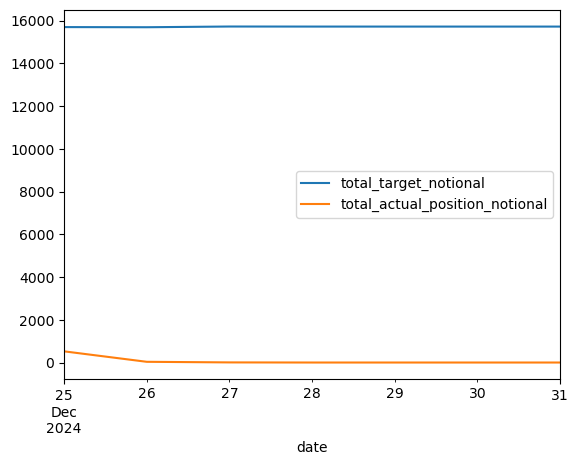

In [83]:
df_month[df_month.index >= pd.Timestamp('2024-12-25')][['total_target_notional','total_actual_position_notional']].plot()

In [268]:
df.index[start_index_position + 1:293]

DatetimeIndex(['2023-01-06', '2023-01-07', '2023-01-08', '2023-01-09',
               '2023-01-10', '2023-01-11', '2023-01-12', '2023-01-13',
               '2023-01-14', '2023-01-15',
               ...
               '2023-10-15', '2023-10-16', '2023-10-17', '2023-10-18',
               '2023-10-19', '2023-10-20', '2023-10-21', '2023-10-22',
               '2023-10-23', '2023-10-24'],
              dtype='datetime64[ns]', name='date', length=292, freq='D')

In [298]:
df = df_signal.copy()
ticker_list = final_month_ticker_list

# Ensure DatetimeIndex (tz-naive), normalized, sorted
if not isinstance(df.index, pd.DatetimeIndex):
    df.index = pd.to_datetime(df.index, utc=True).tz_localize(None)
elif df.index.tz is not None:
    df.index = df.index.tz_localize(None)
df.index = df.index.normalize()
df.sort_index(inplace=True)

## Calculate the covariance matrix for tickers in the portfolio
returns_cols = [f'{ticker}_t_1_close_pct_returns' for ticker in ticker_list]
cov_matrix = df[returns_cols].rolling(rolling_cov_window).cov(pairwise=True).dropna()

## Delete rows prior to the first available date of the covariance matrix
cov_matrix_start_date = cov_matrix.index[0][0]
df = df[df.index >= cov_matrix_start_date]

## Derive the Daily Target Portfolio Volatility
daily_target_volatility = annualized_target_volatility / np.sqrt(annual_trading_days)

## Reorder dataframe columns
for ticker in ticker_list:
    df[f'{ticker}_new_position_size'] = 0.0
    df[f'{ticker}_new_position_notional'] = 0.0
    df[f'{ticker}_open_position_size'] = 0.0
    df[f'{ticker}_open_position_notional'] = 0.0
    df[f'{ticker}_actual_position_size'] = 0.0
    df[f'{ticker}_actual_position_notional'] = 0.0
    df[f'{ticker}_short_sale_proceeds'] = 0.0
    df[f'{ticker}_new_position_entry_exit_price'] = 0.0
    df[f'{ticker}_target_vol_normalized_weight'] = 0.0
    df[f'{ticker}_target_notional'] = 0.0
    df[f'{ticker}_target_size'] = 0.0
    df[f'{ticker}_stop_loss'] = 0.0
    df[f'{ticker}_stopout_flag'] = False
    df[f'{ticker}_cooldown_counter'] = 0.0
    df[f'{ticker}_event'] = np.nan
ord_cols = size_bin.reorder_columns_by_ticker(df.columns, ticker_list)
df = df[ord_cols]

## Portfolio Level Cash and Positions are all set to 0
df['daily_portfolio_volatility'] = 0.0
df['available_cash'] = 0.0
df['count_of_positions'] = 0.0
df['total_actual_position_notional'] = 0.0
df['total_target_notional'] = 0.0
df['total_portfolio_value'] = 0.0
df['total_portfolio_value_upper_limit'] = 0.0
df['target_vol_scaling_factor'] = 1.0
df['cash_scaling_factor'] = 1.0
df['final_scaling_factor'] = 1.0
df['cash_shrink_factor'] = 1.0

# --- pick the desired logical start date for THIS run ---
if use_specific_start_date and signal_start_date is not None:
    logical_start = pd.Timestamp(signal_start_date).normalize()   # only for first month
elif start_date is not None:
    logical_start = pd.Timestamp(start_date).normalize()          # month’s first day
else:
    logical_start = df.index[0]                                   # fallback

# --- align to available index after the cov trimming you did above ---
# df already trimmed by cov_matrix_start_date; its first index may be > logical_start
pos = df.index.searchsorted(logical_start, side="left")
start_index_position = int(min(pos, len(df.index)-1))

## TODO: ADD PREVIOUS MONTH OPEN POSITIONS, AVAILABLE CASH AND TOTAL PORTFOLIO VALUE HERE
if previous_month_open_positions_df is not None:
    df.iloc[start_index_position, df.columns.get_loc('available_cash')]        = previous_month_open_positions_df['available_cash'].iloc[0]
    df.iloc[start_index_position, df.columns.get_loc('total_portfolio_value')] = previous_month_open_positions_df['total_portfolio_value'].iloc[0]
    prev_month_open_ticker_list = [col.split('_')[0] for col in previous_month_open_positions_df.columns if '_actual_position_notional' in col]
    for ticker in prev_month_open_ticker_list:
        df.iloc[start_index_position, df.columns.get_loc(f'{ticker}_actual_position_notional')] = previous_month_open_positions_df[f'{ticker}_actual_position_notional'].iloc[0]
        df.iloc[start_index_position, df.columns.get_loc(f'{ticker}_actual_position_size')]     = previous_month_open_positions_df[f'{ticker}_actual_position_size'].iloc[0]

        # NEW: seed elapsed + flag for prod logic
        elapsed = int(previous_month_open_positions_df.get(f"{ticker}_cooldown_counter", pd.Series([0])).iloc[0])
        df.iloc[start_index_position, df.columns.get_loc(f"{ticker}_cooldown_counter")] = elapsed
        
        stop = bool(previous_month_open_positions_df.get(f"{ticker}_stopout_flag", pd.Series([elapsed > 0])).iloc[0])
        df.iloc[start_index_position, df.columns.get_loc(f"{ticker}_stopout_flag")] = stop

else:
    print('Previous Month End Not Available')
    df.iloc[start_index_position, df.columns.get_loc('available_cash')]        = initial_capital
    df.iloc[start_index_position, df.columns.get_loc('total_portfolio_value')] = initial_capital

## Identify Daily Positions starting from day 2
for date in df.index[start_index_position + 1:295]:
    previous_date = df.index[df.index.get_loc(date) - 1]

    ## Start the day with the available cash from yesterday
    df.loc[date, 'available_cash'] = df.loc[previous_date, 'available_cash']

    ## Roll Portfolio Value from the Previous Day
    total_portfolio_value = df.loc[previous_date, 'total_portfolio_value']
    df.loc[date, 'total_portfolio_value'] = total_portfolio_value

    ## Update Total Portfolio Value Upper Limit based on the Total Portfolio Value
    total_portfolio_value_upper_limit = (df.loc[date, 'total_portfolio_value'] *
                                         (1 - cash_buffer_percentage))
    df.loc[date, 'total_portfolio_value_upper_limit'] = total_portfolio_value_upper_limit

    ## Calculate the target notional by ticker
    df = size_cont.get_target_volatility_position_sizing(df, cov_matrix, date, ticker_list, daily_target_volatility,
                                                         total_portfolio_value_upper_limit)

    ## Adjust Positions for Cash Available
    # desired_positions, cash_shrink_factor = size_cont.get_cash_adjusted_desired_positions(
    #     df, date, previous_date, ticker_list, cash_buffer_percentage, transaction_cost_est, passive_trade_rate,
    #     total_portfolio_value, notional_threshold_pct, min_trade_notional_abs)
    desired_positions, cash_shrink_factor = get_cash_adjusted_desired_positions_expanded_universe(
        df, date, previous_date, ticker_list, cash_buffer_percentage, transaction_cost_est, passive_trade_rate,
        total_portfolio_value, 
        portfolio_trade_floor_bps = portfolio_trade_floor_bps,     # e.g., 10 bps of PV = 0.10% * PV
        position_trade_floor_pct = position_trade_floor_pct,      # e.g., 10% of |target_notional| for rebalances
        entry_trade_floor_pct = entry_trade_floor_pct,         # e.g., 5% of |target_notional| for NEW positions
        min_trade_notional_abs = min_trade_notional_abs,       # absolute $ floor
        use_edge_vs_cost = use_edge_vs_cost,               # require trade > k * fees?
        edge_fee_multiplier = edge_fee_multiplier,            # trade notional must exceed k×fees
        # keep compatibility args (ignored internally)
        notional_threshold_pct = notional_threshold_pct)

    ## Build current notional *from previous_date* for the union ticker_list
    current_notional_prev = df.loc[previous_date, [f"{t}_actual_position_notional" for t in ticker_list]]
    current_notional_prev.index = [c.replace("_actual_position_notional","") for c in current_notional_prev.index]

    # Convert your desired_positions dict to a Series keyed by ticker -> notional delta
    desired_delta = pd.Series(
        {t: desired_positions[t]['new_trade_notional'] for t in desired_positions},
        dtype=float
    ).reindex(current_notional_prev.index).fillna(0.0)

    ## NEW (3): daily liquidity eligibility -> hard exit
    if force_exit_if_ineligible and (eligibility_by_date is not None):
        ## These include all coins that are in today's ticker list and are eligible
        ## This returns the set of common elements between eligibility_by_date and ticker_list
        today_set = set(eligibility_by_date.get(pd.Timestamp(date).date(), ticker_list))
        drops = [t for t in ticker_list if t not in today_set and float(current_notional_prev.get(t, 0.0)) != 0.0]
        if drops:
            # Full flatten: set delta = -current_notional
            # (If you want a “reduce-only” when negative PnL, this is where you'd do it; here we just flatten.)
            desired_delta.loc[drops] = -current_notional_prev.loc[drops].astype(float)
            # optional: mark events (per-ticker columns already exist)
            for t in drops:
                df.loc[date, f'{t}_event'] = 'Liquidity Exit'

            # Also block *new* entries for ineligible tickers
            blocks = [t for t in ticker_list if t not in today_set and float(current_notional_prev.get(t, 0.0)) == 0.0]
            if blocks:
                desired_delta.loc[blocks] = 0.0
    
    ## NEW (2): freeze policy now *allows* adds if you wish
    desired_delta = enforce_freeze_on_notional_deltas(
        desired_delta, current_notional_prev,
        frozen_tickers=frozen_ticker_list,
        allow_adds_on_frozen=allow_adds_on_frozen
    )

    ## NEW (1): apply per-asset caps to post-trade notionals
    desired_delta = clamp_to_per_asset_caps(
        desired_delta=desired_delta,
        current_notional_prev=current_notional_prev,
        total_portfolio_value_upper_limit=total_portfolio_value_upper_limit,
        per_asset_weight_cap=per_asset_weight_cap,
        per_asset_notional_cap=per_asset_notional_cap
    )

    # ---- NEW: Daily position budget (entries only) ----
    today_signals = _get_today_signals(df, date, ticker_list, signal_col_suffix)
    desired_delta = _enforce_daily_position_budget(
        desired_delta=desired_delta,
        current_notional_prev=current_notional_prev,
        today_signals=today_signals,
        max_positions=max_positions,
        max_new_per_day=max_new_per_day
    )
    
    ## Write back to your dict structure (if your downstream expects the nested dict)
    for t in desired_positions:
        desired_positions[t]['new_trade_notional'] = float(desired_delta.get(t, 0.0))

    ## Get the daily positions
    df = size_cont.get_daily_positions_and_portfolio_cash(
        df, date, previous_date, desired_positions, cash_shrink_factor, ticker_list,
        stop_loss_strategy, rolling_atr_window, atr_multiplier, highest_high_window,
        transaction_cost_est, passive_trade_rate, cooldown_counter_threshold)

In [288]:
df.index[start_index_position + 1:293]

DatetimeIndex(['2023-01-06', '2023-01-07', '2023-01-08', '2023-01-09',
               '2023-01-10', '2023-01-11', '2023-01-12', '2023-01-13',
               '2023-01-14', '2023-01-15',
               ...
               '2023-10-15', '2023-10-16', '2023-10-17', '2023-10-18',
               '2023-10-19', '2023-10-20', '2023-10-21', '2023-10-22',
               '2023-10-23', '2023-10-24'],
              dtype='datetime64[ns]', name='date', length=292, freq='D')

In [294]:
total = 0
for k, v in desired_positions.items():
    total += v['new_trade_notional']
    print(k, v['new_trade_notional'], total)

BTC-USD 0.0 0.0
ETH-USD 0.0 0.0
ZEC-USD 0.0 0.0
DOGE-USD 0.0 0.0
LINK-USD 0.0 0.0
ADA-USD 0.0 0.0
AVAX-USD 0.0 0.0
LTC-USD 0.0 0.0
AAVE-USD 0.0 0.0
DOT-USD 0.0 0.0
APT-USD 0.0 0.0
ICP-USD 0.0 0.0
UNI-USD 0.0 0.0
NEAR-USD 0.0 0.0
ATOM-USD 0.0 0.0
JASMY-USD 0.0 0.0
SHIB-USD 0.0 0.0
FIL-USD 0.0 0.0
ETC-USD 0.0 0.0
CRO-USD 0.0 0.0
ALGO-USD 0.0 0.0
CBETH-USD 0.0 0.0
QNT-USD 0.0 0.0
IMX-USD 0.0 0.0
LDO-USD 0.0 0.0
HFT-USD 0.0 0.0
AMP-USD 0.0 0.0
GRT-USD 0.0 0.0
SUSHI-USD 0.0 0.0
STX-USD 0.0 0.0
MANA-USD 0.0 0.0
ROSE-USD 0.0 0.0
OCEAN-USD 0.0 0.0
SAND-USD 0.0 0.0
YFI-USD 0.0 0.0
LRC-USD 0.0 0.0
XTZ-USD 0.0 0.0
ANKR-USD 0.0 0.0
EOS-USD 0.0 0.0
AXS-USD 0.0 0.0
PYR-USD 0.0 0.0
FLOW-USD 0.0 0.0


In [296]:
df.loc[date]['available_cash']

0.0

In [282]:
cash_shrink_factor

1.0

In [273]:
desired_delta

BTC-USD      0.000000e+00
ETH-USD      0.000000e+00
ZEC-USD      5.863123e+02
DOGE-USD     0.000000e+00
LINK-USD     2.593892e-29
ADA-USD      1.778201e+03
AVAX-USD     0.000000e+00
LTC-USD      0.000000e+00
AAVE-USD     4.673455e-32
DOT-USD      0.000000e+00
APT-USD      0.000000e+00
ICP-USD      0.000000e+00
UNI-USD      0.000000e+00
NEAR-USD     0.000000e+00
ATOM-USD     0.000000e+00
JASMY-USD    0.000000e+00
SHIB-USD     0.000000e+00
FIL-USD      7.007953e+01
ETC-USD      0.000000e+00
CRO-USD      2.930273e+02
ALGO-USD     1.469380e+03
CBETH-USD    0.000000e+00
QNT-USD      0.000000e+00
IMX-USD      0.000000e+00
LDO-USD      0.000000e+00
HFT-USD      0.000000e+00
AMP-USD      0.000000e+00
GRT-USD      0.000000e+00
SUSHI-USD    1.975260e+03
STX-USD     -2.391845e+00
MANA-USD     1.363856e+03
ROSE-USD     3.521717e+02
OCEAN-USD    0.000000e+00
SAND-USD     3.287743e+02
YFI-USD      0.000000e+00
LRC-USD      0.000000e+00
XTZ-USD      1.578210e+02
ANKR-USD     6.598288e+02
EOS-USD     

In [274]:
df_month[df_month.index >= pd.Timestamp('2023-10-23')].head()

,BTC-USD_20_avg_true_range_price,BTC-USD_actual_position_notional,BTC-USD_actual_position_size,BTC-USD_annualized_volatility_30,BTC-USD_close,BTC-USD_cooldown_counter,BTC-USD_event,BTC-USD_final_signal,BTC-USD_final_weighted_additive_signal,BTC-USD_highest_high_56,BTC-USD_lowest_low_56,BTC-USD_new_position_entry_exit_price,BTC-USD_new_position_notional,BTC-USD_new_position_size,BTC-USD_open,BTC-USD_open_position_notional,BTC-USD_open_position_size,BTC-USD_short_sale_proceeds,BTC-USD_stop_loss,BTC-USD_stopout_flag,BTC-USD_t_1_close,BTC-USD_t_1_close_pct_returns,BTC-USD_target_notional,BTC-USD_target_size,BTC-USD_target_vol_normalized_weight,BTC-USD_vol_adjusted_trend_signal,ETH-USD_20_avg_true_range_price,ETH-USD_actual_position_notional,ETH-USD_actual_position_size,ETH-USD_annualized_volatility_30,ETH-USD_close,ETH-USD_cooldown_counter,ETH-USD_event,ETH-USD_final_signal,ETH-USD_final_weighted_additive_signal,ETH-USD_highest_high_56,ETH-USD_lowest_low_56,ETH-USD_new_position_entry_exit_price,ETH-USD_new_position_notional,ETH-USD_new_position_size,ETH-USD_open,ETH-USD_open_position_notional,ETH-USD_open_position_size,ETH-USD_short_sale_proceeds,ETH-USD_stop_loss,ETH-USD_stopout_flag,ETH-USD_t_1_close,ETH-USD_t_1_close_pct_returns,ETH-USD_target_notional,ETH-USD_target_size,ETH-USD_target_vol_normalized_weight,ETH-USD_vol_adjusted_trend_signal,ZEC-USD_20_avg_true_range_price,ZEC-USD_actual_position_notional,ZEC-USD_actual_position_size,ZEC-USD_annualized_volatility_30,ZEC-USD_close,ZEC-USD_cooldown_counter,ZEC-USD_event,ZEC-USD_final_signal,ZEC-USD_final_weighted_additive_signal,ZEC-USD_highest_high_56,ZEC-USD_lowest_low_56,ZEC-USD_new_position_entry_exit_price,ZEC-USD_new_position_notional,ZEC-USD_new_position_size,ZEC-USD_open,ZEC-USD_open_position_notional,ZEC-USD_open_position_size,ZEC-USD_short_sale_proceeds,ZEC-USD_stop_loss,ZEC-USD_stopout_flag,ZEC-USD_t_1_close,ZEC-USD_t_1_close_pct_returns,ZEC-USD_target_notional,ZEC-USD_target_size,ZEC-USD_target_vol_normalized_weight,ZEC-USD_vol_adjusted_trend_signal,DOGE-USD_20_avg_true_range_price,DOGE-USD_actual_position_notional,DOGE-USD_actual_position_size,DOGE-USD_annualized_volatility_30,DOGE-USD_close,DOGE-USD_cooldown_counter,DOGE-USD_event,DOGE-USD_final_signal,DOGE-USD_final_weighted_additive_signal,DOGE-USD_highest_high_56,DOGE-USD_lowest_low_56,DOGE-USD_new_position_entry_exit_price,DOGE-USD_new_position_notional,DOGE-USD_new_position_size,DOGE-USD_open,DOGE-USD_open_position_notional,DOGE-USD_open_position_size,DOGE-USD_short_sale_proceeds,DOGE-USD_stop_loss,DOGE-USD_stopout_flag,DOGE-USD_t_1_close,DOGE-USD_t_1_close_pct_returns,DOGE-USD_target_notional,DOGE-USD_target_size,DOGE-USD_target_vol_normalized_weight,DOGE-USD_vol_adjusted_trend_signal,LINK-USD_20_avg_true_range_price,LINK-USD_actual_position_notional,LINK-USD_actual_position_size,LINK-USD_annualized_volatility_30,LINK-USD_close,LINK-USD_cooldown_counter,LINK-USD_event,LINK-USD_final_signal,LINK-USD_final_weighted_additive_signal,LINK-USD_highest_high_56,LINK-USD_lowest_low_56,LINK-USD_new_position_entry_exit_price,LINK-USD_new_position_notional,LINK-USD_new_position_size,LINK-USD_open,LINK-USD_open_position_notional,LINK-USD_open_position_size,LINK-USD_short_sale_proceeds,LINK-USD_stop_loss,LINK-USD_stopout_flag,LINK-USD_t_1_close,LINK-USD_t_1_close_pct_returns,LINK-USD_target_notional,LINK-USD_target_size,LINK-USD_target_vol_normalized_weight,LINK-USD_vol_adjusted_trend_signal,ADA-USD_20_avg_true_range_price,ADA-USD_actual_position_notional,ADA-USD_actual_position_size,ADA-USD_annualized_volatility_30,ADA-USD_close,ADA-USD_cooldown_counter,ADA-USD_event,ADA-USD_final_signal,ADA-USD_final_weighted_additive_signal,ADA-USD_highest_high_56,ADA-USD_lowest_low_56,ADA-USD_new_position_entry_exit_price,ADA-USD_new_position_notional,ADA-USD_new_position_size,ADA-USD_open,ADA-USD_open_position_notional,ADA-USD_open_position_size,ADA-USD_short_sale_proceeds,ADA-USD_stop_loss,ADA-USD_stopout_flag,ADA-USD_t_1_close,ADA-US

In [284]:
df_month[df_month.index >= pd.Timestamp('2023-10-23')][zec_cols].head()

,ZEC-USD_20_avg_true_range_price,ZEC-USD_actual_position_notional,ZEC-USD_actual_position_size,ZEC-USD_annualized_volatility_30,ZEC-USD_close,ZEC-USD_cooldown_counter,ZEC-USD_event,ZEC-USD_final_signal,ZEC-USD_final_weighted_additive_signal,ZEC-USD_highest_high_56,ZEC-USD_lowest_low_56,ZEC-USD_new_position_entry_exit_price,ZEC-USD_new_position_notional,ZEC-USD_new_position_size,ZEC-USD_open,ZEC-USD_open_position_notional,ZEC-USD_open_position_size,ZEC-USD_short_sale_proceeds,ZEC-USD_stop_loss,ZEC-USD_stopout_flag,ZEC-USD_t_1_close,ZEC-USD_t_1_close_pct_returns,ZEC-USD_target_notional,ZEC-USD_target_size,ZEC-USD_target_vol_normalized_weight,ZEC-USD_vol_adjusted_trend_signal
date,,,,,,,,,,,,,,,,,,,,,,,,,,
2023-10-23,0.816597,0.0,0.0,0.346838,27.26,0.0,Entry Blocked by Chandelier (Long),0.038922,0.231969,28.29,23.61,25.87,0.0,0.0,25.87,0.0,0.0,0.0,NaN,False,25.87,0.009364,943.616258,36.475310,0.061774,0.112220
2023-10-24,0.915968,0.0,0.0,0.395507,27.49,0.0,No Position,0.032596,0.274656,28.29,23.61,27.26,0.0,0.0,27.26,0.0,0.0,0.0,NaN,False,27.26,0.053730,691.934956,25.382794,0.045298,0.082416
2023-10-25,0.971590,0.0,0.0,0.382593,27.41,0.0,No Position,0.018617,0.313726,28.29,23.61,27.52,0.0,0.0,27.52,0.0,0.0,0.0,NaN,False,27.49,0.008437,343.138180,12.482291,0.022381,0.048659
2023-10-26,0.974296,0.0,0.0,0.382218,27.78,0.0,No Position,0.010280,0.346484,28.29,23.61,27.44,0.0,0.0,27.44,0.0,0.0,0.0,NaN,False,27.41,-0.002910,160.068016,5.839767,0.010450,0.026896
2023-10-27,1.070077,0.0,0.0,0.384252,27.34,0.0,No Position,0.005599,0.377448,28.89,23.61,27.86,0.0,0.0,27.86,0.0,0.0,0.0,NaN,False,27.78,0.013499,77.082342,2.774742,0.005029,0.014572


In [299]:
df[df.index >= pd.Timestamp('2023-10-23')][zec_cols].head()

,ZEC-USD_20_avg_true_range_price,ZEC-USD_actual_position_notional,ZEC-USD_actual_position_size,ZEC-USD_annualized_volatility_30,ZEC-USD_close,ZEC-USD_cooldown_counter,ZEC-USD_event,ZEC-USD_final_signal,ZEC-USD_final_weighted_additive_signal,ZEC-USD_highest_high_56,ZEC-USD_lowest_low_56,ZEC-USD_new_position_entry_exit_price,ZEC-USD_new_position_notional,ZEC-USD_new_position_size,ZEC-USD_open,ZEC-USD_open_position_notional,ZEC-USD_open_position_size,ZEC-USD_short_sale_proceeds,ZEC-USD_stop_loss,ZEC-USD_stopout_flag,ZEC-USD_t_1_close,ZEC-USD_t_1_close_pct_returns,ZEC-USD_target_notional,ZEC-USD_target_size,ZEC-USD_target_vol_normalized_weight,ZEC-USD_vol_adjusted_trend_signal
date,,,,,,,,,,,,,,,,,,,,,,,,,,
2023-10-23,0.816597,0.000000,0.000000,0.346838,27.26,0.0,Entry Blocked by Chandelier (Long),0.038922,0.231969,28.29,23.61,25.87,0.000000,0.000000,25.87,0.000000,0.000000,0.0,NaN,False,25.87,0.009364,799.580246,30.907624,0.061774,0.112220
2023-10-24,0.915968,578.866102,21.235000,0.395507,27.49,0.0,New Long Position,0.032596,0.274656,28.29,23.61,27.26,578.866102,21.235000,27.26,0.000000,0.000000,0.0,26.687055,False,27.26,0.053730,586.312268,21.508154,0.045298,0.082416
2023-10-25,0.971590,297.098431,10.795728,0.382593,27.41,0.0,Trim Long Position,0.018617,0.313726,28.29,23.61,27.52,-287.288771,-10.439272,27.52,584.387202,21.235000,0.0,26.687055,False,27.49,0.008437,293.402931,10.673079,0.022381,0.048659
2023-10-26,0.974296,141.648139,5.162104,0.382218,27.78,0.0,Trim Long Position,0.010280,0.346484,28.29,23.61,27.44,-154.586634,-5.633624,27.44,296.234773,10.795728,0.0,26.687055,False,27.41,-0.002910,139.571526,5.091993,0.010450,0.026896
2023-10-27,1.070077,0.000000,0.000000,0.384252,27.34,0.0,NaN,0.005599,0.377448,28.89,23.61,0.00,0.000000,0.000000,27.86,0.000000,0.000000,0.0,0.000000,False,27.78,0.013499,0.000000,0.000000,0.000000,0.014572


In [163]:
108388.88 - 1.75*4293.906376

100874.543842

In [103]:
date

Timestamp('2024-12-28 00:00:00')

In [105]:
previous_date

Timestamp('2024-12-27 00:00:00')

In [129]:
ticker = 'BTC-USD'
## Define Column Names
open_position_notional_col = f'{ticker}_open_position_notional'
open_position_size_col = f'{ticker}_open_position_size'
actual_position_notional_col = f'{ticker}_actual_position_notional'
actual_position_size_col = f'{ticker}_actual_position_size'
short_sale_proceeds_col = f'{ticker}_short_sale_proceeds'
open_price_col = f'{ticker}_open'
cooldown_counter_col = f'{ticker}_cooldown_counter'
stopout_flag_col = f'{ticker}_stopout_flag'
event_col = f'{ticker}_event'

## Roll Positions from Previous Day
df[open_position_size_col].loc[date] = df[actual_position_size_col].loc[previous_date]
df[open_position_notional_col].loc[date] = df[open_position_size_col].loc[date] * df[open_price_col].loc[date]
df[short_sale_proceeds_col].loc[date] = df[short_sale_proceeds_col].loc[previous_date]
df[cooldown_counter_col].loc[date] = df[cooldown_counter_col].loc[previous_date]
df[stopout_flag_col].loc[date] = df[stopout_flag_col].loc[previous_date]

## Define Variables
new_trade_notional = desired_positions[ticker]['new_trade_notional'] * cash_shrink_factor ## THIS IS WRONG, THIS NEEDS TO BE APPLIED BEFORE THE ASSET CAPS ARE APPLIED
trade_fees = desired_positions[ticker]['trade_fees'] * cash_shrink_factor ## THIS IS WRONG, THIS NEEDS TO BE APPLIED BEFORE THE ASSET CAPS ARE APPLIED

In [131]:
new_trade_notional

2526.525204904458

In [133]:
cash_shrink_factor

0.9947812318719556

In [135]:
new_position_notional_col = f'{ticker}_new_position_notional'
new_position_size_col = f'{ticker}_new_position_size'
open_position_notional_col = f'{ticker}_open_position_notional'
open_position_size_col = f'{ticker}_open_position_size'
actual_position_notional_col = f'{ticker}_actual_position_notional'
actual_position_size_col = f'{ticker}_actual_position_size'
new_position_entry_exit_price_col = f'{ticker}_new_position_entry_exit_price'
target_position_notional_col = f'{ticker}_target_notional'
target_position_size_col = f'{ticker}_target_size'
stop_loss_col = f'{ticker}_stop_loss'
highest_high_col = f'{ticker}_highest_high_{highest_high_window}'
lowest_low_col = f'{ticker}_lowest_low_{highest_high_window}'
cooldown_counter_col = f'{ticker}_cooldown_counter'
stopout_flag_col = f'{ticker}_stopout_flag'
available_cash_col = 'available_cash'
short_sale_proceeds_col = f'{ticker}_short_sale_proceeds'
open_price_col = f'{ticker}_open'
t_1_close_price_col = f'{ticker}_t_1_close'
atr_col = f'{ticker}_{rolling_atr_window}_avg_true_range_price'
event_col = f'{ticker}_event'

## Update Daily Positions
# Open Trade Notional
previous_date = df.index[df.index.get_loc(date) - 1]
open_position_size = df[open_position_size_col].loc[date]
open_price = df[open_price_col].loc[date]
open_position_notional = df[open_position_notional_col].loc[date]
t_1_close_price = df[t_1_close_price_col].loc[date]
atr_value = df[atr_col].loc[date]
target_notional = df[target_position_notional_col].loc[date]
target_size = df[target_position_size_col].loc[date]
est_fees = (transaction_cost_est + perf.estimate_fee_per_trade(passive_trade_rate))
cooldown_counter = df[cooldown_counter_col].loc[date]
stopout_flag = df[stopout_flag_col].loc[date]

In [137]:
target_notional

2539.77972639281

In [141]:
## Implement a Cooldown Counter for Stop Loss Breaches
if cooldown_counter > 0:
    print('Cooldown Counuter > 0')
    # Increment cooldown
    df[cooldown_counter_col].loc[date] = df[cooldown_counter_col].loc[date] + 1

    # Cooldown threshold (e.g., 3 bars)
    if df[cooldown_counter_col].loc[date] <= cooldown_counter_threshold:
        # Still cooling down: block re-entry
        df[event_col].loc[date] = 'Stop-Loss Cooldown'
        print('Stop Loss Cooldown')
        # return df
    else:
        # Cooldown complete: reset
        df[stopout_flag_col].loc[date] = False
        df[cooldown_counter_col].loc[date] = 0

In [147]:
## Check for Stop Loss Breach
if size_cont.handle_stop_loss_breach(df, ticker, date, est_fees, stop_loss_col, open_price, available_cash_col,
                           short_sale_proceeds_col):
    print('Stop Loss Breach!')

In [149]:
## Handle an Explicit Close Position
if np.isclose(target_notional, 0.0) and not np.isclose(open_position_notional, 0.0):
    df, closed = size_cont.handle_explicit_position_close(df, ticker, date, open_position_notional, open_price, est_fees)
    if closed:
        print('Position Closed!')

In [151]:
## Capture ATR and Stop Loss Parameters
atr_t1 = df[atr_col].loc[date]

if stop_loss_strategy == 'Chandelier':
    highest_high_t1 = df[highest_high_col].loc[date]
    lowest_low_t1 = df[lowest_low_col].loc[date]
    base_long_t1 = highest_high_t1 - atr_multiplier * atr_t1
    base_short_t1 = lowest_low_t1 + atr_multiplier * atr_t1
elif stop_loss_strategy == 'Default':
    base_long_t1 = t_1_close_price - atr_multiplier * atr_t1
    base_short_t1 = t_1_close_price + atr_multiplier * atr_t1

prev_stop_loss = df[stop_loss_col].loc[previous_date]

In [153]:
prev_stop_loss

nan

In [155]:
base_long_t1

100874.54384255176

In [157]:
open_price

94171.7

In [159]:
# ---------- entry eligibility gate (prevents instant-stop entries) ----------
# If target says "go long" but open <= long base -> block NEW long entry today (keep trims/closes).
# If target says "go short" but open >= short base -> block NEW short entry today.
# This only blocks fresh exposure; if you already have a position, normal trading proceeds.
if np.isfinite(atr_t1):
    if target_notional > 0 and open_position_notional <= 0 and open_price <= base_long_t1:
        print('If target says "go long" but open <= long base -> block NEW long entry today (keep trims/closes)')
        new_trade_notional = 0.0
        df[event_col].loc[date] = f'Entry Blocked by {stop_loss_strategy} (Long)'
    if target_notional < 0 and open_position_notional >= 0 and open_price >= base_short_t1:
        new_trade_notional = 0.0
        df[event_col].loc[date] = f'Entry Blocked by {stop_loss_strategy} (Short)'

If target says "go long" but open <= long base -> block NEW long entry today (keep trims/closes)


In [143]:
df[stopout_flag_col].loc[date]

False

In [ ]:
## Build current notional *from previous_date* for the union ticker_list
current_notional_prev = df.loc[previous_date, [f"{t}_actual_position_notional" for t in ticker_list]]
current_notional_prev.index = [c.replace("_actual_position_notional","") for c in current_notional_prev.index]

# Convert your desired_positions dict to a Series keyed by ticker -> notional delta
desired_delta = pd.Series(
    {t: desired_positions[t]['new_trade_notional'] for t in desired_positions},
    dtype=float
).reindex(current_notional_prev.index).fillna(0.0)

## NEW (3): daily liquidity eligibility -> hard exit
if force_exit_if_ineligible and (eligibility_by_date is not None):
    ## These include all coins that are in today's ticker list and are eligible
    ## This returns the set of common elements between eligibility_by_date and ticker_list
    today_set = set(eligibility_by_date.get(pd.Timestamp(date).date(), ticker_list))
    drops = [t for t in ticker_list if t not in today_set and float(current_notional_prev.get(t, 0.0)) != 0.0]
    if drops:
        # Full flatten: set delta = -current_notional
        # (If you want a “reduce-only” when negative PnL, this is where you'd do it; here we just flatten.)
        desired_delta.loc[drops] = -current_notional_prev.loc[drops].astype(float)
        # optional: mark events (per-ticker columns already exist)
        for t in drops:
            df.loc[date, f'{t}_event'] = 'Liquidity Exit'

        # Also block *new* entries for ineligible tickers
        blocks = [t for t in ticker_list if t not in today_set and float(current_notional_prev.get(t, 0.0)) == 0.0]
        if blocks:
            desired_delta.loc[blocks] = 0.0

## NEW (2): freeze policy now *allows* adds if you wish
desired_delta = enforce_freeze_on_notional_deltas(
    desired_delta, current_notional_prev,
    frozen_tickers=frozen_ticker_list,
    allow_adds_on_frozen=allow_adds_on_frozen
)

## NEW (1): apply per-asset caps to post-trade notionals
desired_delta = clamp_to_per_asset_caps(
    desired_delta=desired_delta,
    current_notional_prev=current_notional_prev,
    total_portfolio_value_upper_limit=total_portfolio_value_upper_limit,
    per_asset_weight_cap=per_asset_weight_cap,
    per_asset_notional_cap=per_asset_notional_cap
)

# ---- NEW: Daily position budget (entries only) ----
today_signals = _get_today_signals(df, date, ticker_list, signal_col_suffix)
desired_delta = _enforce_daily_position_budget(
    desired_delta=desired_delta,
    current_notional_prev=current_notional_prev,
    today_signals=today_signals,
    max_positions=max_positions,
    max_new_per_day=max_new_per_day
)

In [ ]:
max_positions

In [ ]:
max_new_per_day

In [ ]:
today_signals

In [ ]:
desired_delta.sum()

In [ ]:
desired_positions

In [ ]:
total_portfolio_value

In [ ]:
desired_positions = {}
cash_debit = 0.0   # buys (executed) + fees counted in buys later by your order layer
cash_credit = 0.0  # sells (executed) - fees

# Available cash after buffer
available_cash = float(df['available_cash'].loc[date]) * (1.0 - float(cash_buffer_percentage))

# Estimated transaction costs + fees as a RATE (e.g., 0.0005 == 5 bps)
# Keep this consistent with the rest of your stack.
est_fees_rate = float(transaction_cost_est) + float(perf.estimate_fee_per_trade(passive_trade_rate))

# Floors that depend on PV (bps)
floor_pv_usd = (float(portfolio_trade_floor_bps) / 1e4) * float(total_portfolio_value)

for ticker in ticker_list:
    # Pull today/previous notions robustly
    target_notional = float(df[f'{ticker}_target_notional'].loc[date])
    prev_units = float(df[f'{ticker}_actual_position_size'].loc[previous_date])
    px_open = float(df[f'{ticker}_open'].loc[date])

    current_notional = prev_units * px_open
    delta_notional = target_notional - current_notional
    is_new_position = (abs(current_notional) <= 1e-8) and (abs(target_notional) > 1e-8)

    # Position % floor (smaller for entries)
    pos_floor_pct = float(entry_trade_floor_pct) if is_new_position else float(position_trade_floor_pct)
    floor_pos_usd = pos_floor_pct * abs(target_notional)

    # Absolute floor
    floor_abs_usd = float(min_trade_notional_abs)

    # Final notional floor for this ticker
    notional_floor = max(floor_pv_usd, floor_pos_usd, floor_abs_usd)

    # Fees estimate for THIS potential trade
    est_trade_fees_usd = abs(delta_notional) * est_fees_rate

    # Execute only if above floors (and optionally materially larger than fees)
    execute = abs(delta_notional) > notional_floor
    if use_edge_vs_cost:
        execute = execute and (abs(delta_notional) > edge_fee_multiplier * est_trade_fees_usd)

    # Only executed trades affect desired_positions and cash math
    eff_delta = delta_notional if execute else 0.0
    eff_fees  = (abs(eff_delta) * est_fees_rate) if execute else 0.0

    desired_positions[ticker] = {
        'new_trade_notional': eff_delta,
        'trade_fees': eff_fees,
        'notional_floor': notional_floor,
        'is_new': bool(is_new_position),
    }

    # Cash flow accounting for executed trades ONLY
    if eff_delta >= 0:
        # Buys: consume cash by gross notional; fees are handled when orders are placed
        cash_debit += eff_delta
    else:
        # Sells: realize cash; net of fees
        # original logic: net_trade_notional = new_trade_notional + trade_fees (negative + fee)
        # cash_credit += abs(net_trade_notional) == abs(delta) - fees
        cash_credit += (abs(eff_delta) - eff_fees)

# Net cash required for the executed set
net_cash_need = cash_debit - cash_credit
if net_cash_need > (available_cash + 1e-6):
    cash_shrink_factor = available_cash / net_cash_need  # 0 < shrink < 1
else:
    cash_shrink_factor = 1.0

# Persist for diagnostics
df.loc[date, 'cash_shrink_factor'] = cash_shrink_factor

In [ ]:
total = 0
for k, v in desired_positions.items():
    print(k, v['new_trade_notional'], total)
    total += v['new_trade_notional']

In [ ]:
# Scale weights of positions to ensure the portfolio is in line with the target volatility
unscaled_weight_cols = [f'{ticker}_vol_adjusted_trend_signal' for ticker in ticker_list]
scaled_weight_cols = [f'{ticker}_target_vol_normalized_weight' for ticker in ticker_list]
target_notional_cols = [f'{ticker}_target_notional' for ticker in ticker_list]
t_1_price_cols = [f'{ticker}_t_1_close' for ticker in ticker_list]
returns_cols = [f'{ticker}_t_1_close_pct_returns' for ticker in ticker_list]

if date not in df.index or date not in cov_matrix.index:
    raise ValueError(f"Date {date} not found in DataFrame or covariance matrix index.")

## Iterate through each day and calculate the covariance matrix, portfolio volatility and scaling factors
daily_weights = df.loc[date, unscaled_weight_cols].values
daily_cov_matrix = cov_matrix.loc[date].loc[returns_cols, returns_cols].values
daily_portfolio_volatility = size_bin.calculate_portfolio_volatility(daily_weights, daily_cov_matrix)
df.loc[date, 'daily_portfolio_volatility'] = daily_portfolio_volatility
daily_target_volatility = 0.45 / np.sqrt(annual_trading_days)
if daily_portfolio_volatility > 0:
    vol_scaling_factor = daily_target_volatility / daily_portfolio_volatility
else:
    vol_scaling_factor = 0

## Apply Scaling Factor with No Leverage
gross_weight_sum = np.sum(np.abs(daily_weights))
cash_scaling_factor = 1.0 / np.maximum(gross_weight_sum, 1e-12)            # ∑ w ≤ 1  (long‑only)
final_scaling_factor = min(vol_scaling_factor, cash_scaling_factor)

df.loc[date, 'target_vol_scaling_factor'] = vol_scaling_factor
df.loc[date, 'cash_scaling_factor'] = cash_scaling_factor
df.loc[date, 'final_scaling_factor'] = final_scaling_factor

# Scale the weights to target volatility
scaled_weights = daily_weights * final_scaling_factor
df.loc[date, scaled_weight_cols] = scaled_weights

## Calculate the target notional and size
target_notionals = scaled_weights * total_portfolio_value_upper_limit
df.loc[date, target_notional_cols] = target_notionals
target_sizes = target_notionals / df.loc[date, t_1_price_cols].values

for i, ticker in enumerate(ticker_list):
    df.loc[date, f'{ticker}_target_size'] = target_sizes[i]

total_target_notional = target_notionals.sum()
df.loc[date, 'total_target_notional'] = total_target_notional

In [ ]:
df[df.index >= pd.Timestamp('2024-12-25')].head()

In [ ]:
total_target_notional

In [ ]:
target_notionals.sum()

In [ ]:
daily_portfolio_volatility

In [ ]:
daily_target_volatility

In [ ]:
vol_scaling_factor

In [ ]:
daily_weights

In [ ]:
total_portfolio_value_upper_limit

In [ ]:
df[df.index >= pd.Timestamp('2024-12-25')].head()

In [ ]:
df[df.index >= pd.Timestamp('2024-12-25')][target_notional_cols].head()

In [ ]:
desired_positions

## Analyze Performance of Strategy with Expanded Universe

In [47]:
from pathlib import Path
import pyarrow.dataset as ds
import pandas as pd

# ---------- small utilities ----------
def _norm(ts): 
    return pd.Timestamp(ts).normalize()

def _ym_pairs(start, end):
    d = pd.date_range(_norm(start), _norm(end), freq="MS")
    return [(x.year, x.month) for x in d]

def _partition_filter(pairs):
    f = None
    for y, m in pairs:
        cond = (ds.field("year") == y) & (ds.field("month") == m)
        f = cond if f is None else (f | cond)
    return f

# 1) prev_month_open_positions  (LONG: one row per month-end × ticker)
def read_prev_month_open_positions(root_dir: str | Path, start, end) -> pd.DataFrame:
    root = Path(root_dir)
    pairs = _ym_pairs(start, end)
    # lock schema to avoid string/null mix errors
    import pyarrow as pa
    schema = pa.schema([
        ("date", pa.timestamp("ns")),  # change to "ms" if you wrote ms
        ("ticker", pa.string()),
        ("actual_position_size", pa.float64()),
        ("actual_position_notional", pa.float64()),
        ("available_cash", pa.float64()),
        ("total_portfolio_value", pa.float64()),
        ("year", pa.int32()),
        ("month", pa.int32()),
    ])
    dset = ds.dataset(str(root), format="parquet", partitioning="hive", schema=schema)
    tbl = dset.to_table(filter=_partition_filter(pairs))
    df = tbl.to_pandas()
    if df.empty:
        return df
    df["date"] = pd.to_datetime(df["date"]).dt.normalize()
    mask = (df["date"] >= _norm(start)) & (df["date"] <= _norm(end))
    return df.loc[mask].sort_values(["date", "ticker"]).reset_index(drop=True)

# 2) positions_daily  (LONG: one row per day × product_id, with metrics as columns)
def read_positions_daily(root_dir: str | Path, start, end) -> pd.DataFrame:
    root = Path(root_dir)
    pairs = _ym_pairs(start, end)
    dset = ds.dataset(str(root), format="parquet", partitioning="hive")  # schema can vary by run
    tbl = dset.to_table(filter=_partition_filter(pairs))
    df = tbl.to_pandas()
    if df.empty:
        return df
    df["date"] = pd.to_datetime(df["date"]).dt.normalize()
    mask = (df["date"] >= _norm(start)) & (df["date"] <= _norm(end))
    return df.loc[mask].sort_values(["date", "product_id"]).reset_index(drop=True)

# 3) perf_store  (portfolio-level daily aggregates)
def read_perf_store(root_dir: str | Path, start, end) -> pd.DataFrame:
    root = Path(root_dir)
    pairs = _ym_pairs(start, end)
    dset = ds.dataset(str(root), format="parquet", partitioning="hive")
    # read only needed columns; add more if you stored extras
    cols = ["date","year","month",
            "daily_portfolio_volatility","available_cash","count_of_positions",
            "total_actual_position_notional","total_target_notional",
            "total_portfolio_value","total_portfolio_value_upper_limit"]
    tbl = dset.to_table(filter=_partition_filter(pairs), columns=[c for c in cols if c in dset.schema.names or c in ("year","month")])
    df = tbl.to_pandas()
    if df.empty:
        return df
    df["date"] = pd.to_datetime(df["date"]).dt.normalize()
    mask = (df["date"] >= _norm(start)) & (df["date"] <= _norm(end))
    df = df.loc[mask].sort_values("date")
    # make date the index for convenience
    return df.set_index("date")


In [49]:
MONTH_END_OPEN_POSITION_DIR = Path("/Users/adheerchauhan/Documents/git/trend_following/data_folder/universe/prev_month_open_positions")
POSITIONS_DIR = Path("/Users/adheerchauhan/Documents/git/trend_following/data_folder/universe/positions_daily")
PERF_STORE_DIR = Path("/Users/adheerchauhan/Documents/git/trend_following/data_folder/universe/perf_store")

# OPEN_POS_DIR = "/Users/you/.../prev_month_open_positions"
# POSITIONS_DIR = "/Users/you/.../positions_daily"
# PERF_STORE_DIR = "/Users/you/.../perf_store"

start, end = "2022-04-01", "2024-12-31"

df_open  = read_prev_month_open_positions(MONTH_END_OPEN_POSITION_DIR, start, end)
df_pos   = read_positions_daily(POSITIONS_DIR, start, end)
df_perf  = read_perf_store(PERF_STORE_DIR, start, end)


In [51]:
df_pos.shape

(37067, 17)

In [302]:
df_pos.to_pickle("/Users/adheerchauhan/Documents/git/trend_following/research/backtest_results/expanded_universe/Daily_Positions_No_Position_Constraints-2022-04-01_2024-12-31.pickle")
df_open.to_pickle("/Users/adheerchauhan/Documents/git/trend_following/research/backtest_results/expanded_universe/Monthly_Open_Positions_No_Position_Constraints-2022-04-01_2024-12-31.pickle")
df_perf.to_pickle("/Users/adheerchauhan/Documents/git/trend_following/research/backtest_results/expanded_universe/Daily_Performance_No_Position_Constraints-2022-04-01_2024-12-31.pickle")

In [ ]:
df_pos[df_pos.product_id == 'BTC-USD'][['final_signal']].plot()

<Axes: xlabel='date'>

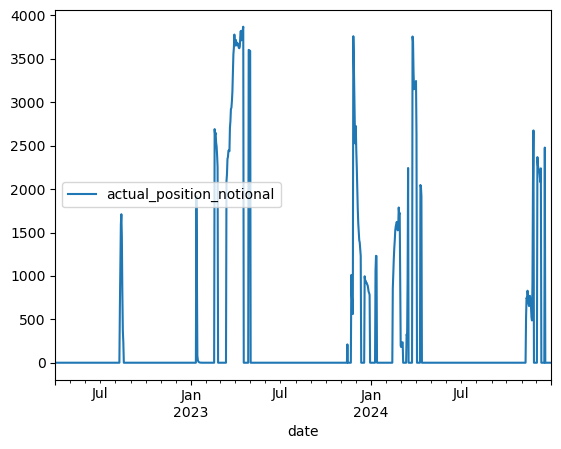

In [189]:
df_pos[df_pos.product_id == 'BTC-USD'].set_index('date')[['actual_position_notional']].plot()

<Axes: xlabel='date'>

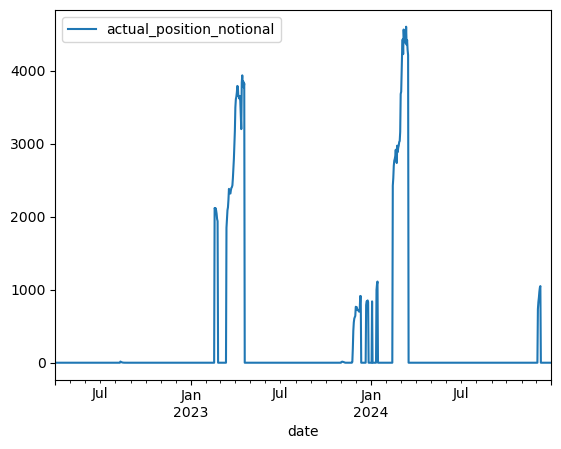

In [219]:
df_pos[df_pos.product_id == 'ETH-USD'].set_index('date')[['actual_position_notional']].plot()

In [205]:
df_pos[(df_pos['date'] >= pd.Timestamp('2023-07-01')) & (df_pos['date'] <= pd.Timestamp('2023-09-01'))].groupby(['product_id']).agg({'actual_position_notional':'sum'})

,actual_position_notional
product_id,
1INCH-USD,0.000000
AAVE-USD,119.762995
ADA-USD,0.000000
ALGO-USD,0.000000
AMP-USD,0.000000
ANKR-USD,0.000000
APE-USD,0.000000
APT-USD,0.000000
ATOM-USD,0.000000


In [213]:
1080.00 - 1.75*87.235512

927.337854

In [217]:
df_pos[(df_pos['date'] >= pd.Timestamp('2023-07-01')) & (df_pos['date'] <= pd.Timestamp('2023-07-06'))].head()

,date,product_id,20_avg_true_range_price,actual_position_notional,actual_position_size,annualized_volatility_30,event,final_signal,final_weighted_additive_signal,highest_high_56,open,stopout_flag,t_1_close,target_notional,target_size,year,month
14740,2023-07-01,AAVE-USD,5.957141,0.0,0.0,1.141238,No Position,0.0,-0.306901,76.85000,70.55000,False,70.50000,0.0,0.0,2023,7
14741,2023-07-01,ADA-USD,0.018564,0.0,0.0,0.732639,No Position,0.0,-0.431313,0.39710,0.28710,False,0.28680,0.0,0.0,2023,7
14742,2023-07-01,ALGO-USD,0.008162,0.0,0.0,0.795896,No Position,0.0,-0.353811,0.18320,0.12170,False,0.12190,0.0,0.0,2023,7
14743,2023-07-01,AMP-USD,0.000146,0.0,0.0,0.729950,No Position,0.0,-0.359985,0.00358,0.00203,False,0.00202,0.0,0.0,2023,7
14744,2023-07-01,ANKR-USD,0.002040,0.0,0.0,0.986764,No Position,0.0,-0.336458,0.03024,0.02301,False,0.02300,0.0,0.0,2023,7


In [211]:
df_pos[(df_pos['date'] >= pd.Timestamp('2023-07-01')) & (df_pos['date'] <= pd.Timestamp('2023-09-01')) & (df_pos.product_id == 'MKR-USD')]#.head()

,date,product_id,20_avg_true_range_price,actual_position_notional,actual_position_size,annualized_volatility_30,event,final_signal,final_weighted_additive_signal,highest_high_56,open,stopout_flag,t_1_close,target_notional,target_size,year,month
14767,2023-07-01,MKR-USD,52.235642,0.637151,7.663868e-04,0.889251,New Long Position,2.929550e-09,0.012246,859.10,831.37,False,831.03,6.453469e-01,7.765627e-04,2023,7
14806,2023-07-02,MKR-USD,52.623676,0.027435,3.253457e-05,0.889323,Trim Long Position,8.849789e-09,0.073986,859.10,843.27,False,841.98,2.607561e-01,3.096940e-04,2023,7
14845,2023-07-03,MKR-USD,56.865231,0.002237,2.603732e-06,0.886747,Trim Long Position,8.430065e-09,0.140953,896.97,859.34,False,859.86,1.629709e-01,1.895319e-04,2023,7
14884,2023-07-04,MKR-USD,72.782828,0.000650,6.663497e-07,0.988476,Trim Long Position,6.585560e-09,0.220225,1074.00,975.29,False,975.90,2.987690e-02,3.061472e-05,2023,7
14923,2023-07-05,MKR-USD,74.313987,0.000230,2.344242e-07,0.988879,Trim Long Position,4.296424e-09,0.287351,1074.00,981.51,False,980.62,1.844095e-02,1.880540e-05,2023,7
14962,2023-07-06,MKR-USD,87.235512,0.000000,0.000000e+00,1.002821,Close Long Position,2.479969e-09,0.331727,1080.00,916.48,True,916.99,1.136710e-02,1.239610e-05,2023,7
15001,2023-07-07,MKR-USD,91.022606,0.000000,0.000000e+00,1.011562,Stop-Loss Cooldown,1.395645e-09,0.373370,1080.00,965.58,True,965.60,3.542778e-03,3.668991e-06,2023,7
15040,2023-07-08,MKR-USD,96.287120,0.000000,0.000000e+00,1.001616,Stop-Loss Cooldown,7.506946e-10,0.401660,1080.00,943.80,True,943.81,6.688706e-04,7.086920e-07,2023,7
15079,2023-07-09,MKR-USD,93.007394,0.000000,0.000000e+00,1.005188,Stop-Loss Cooldown,3.929373e-10,0.420483,1080.00,931.98,True,931.97,3.256507e-04,3.494218e-07,2023,7
15118,2023-07-10,MKR-USD,92.529547,0.000000,0.000000e+00,1.006096,Stop-Loss Cooldown,2.042536e-10,0.437144,1080.00,961.51,True,961.10,2.101238e-04,2.186284e-07,2023,7


In [235]:
df_pos[(df_pos['date'] >= pd.Timestamp('2023-10-01')) & (df_pos['date'] <= pd.Timestamp('2023-12-01')) & (df_pos.target_notional != 0)].groupby(['date','product_id']).agg({'target_notional':'sum','actual_position_notional':'sum'})

target_notional  actual_position_notional
date       product_id                                           
2023-10-01 AAVE-USD       2.423362e-24                  0.000000
           ALGO-USD       8.599542e+03                  0.000000
           FLOW-USD       5.495903e+02                  0.000000
           HFT-USD        1.022044e+03                  0.000000
           JASMY-USD      1.549246e+03                  0.000000
           LINK-USD       5.587223e-21                  0.000000
           SUSHI-USD      2.536615e-13                  0.000000
           ZEC-USD        3.613630e+03                  0.000000
2023-10-02 AAVE-USD       1.515639e-24                  0.000000
           ALGO-USD       7.546240e+03                  0.000000
           FLOW-USD       1.088167e+03                  0.000000
           HFT-USD        1.076548e+03                  0.000000
           JASMY-USD      1.675997e+03                  0.000000
           LINK-USD       2.737334e-21                  0.000000
           SUSHI-USD      1.261351e-13                  0.000000
           ZEC-USD        3.947101e+03                  0.000000
2023-10-03 AAVE-USD       9.234095e-25                  0.000000
           ALGO-USD       6.896990e+03                  0.000000
           FLOW-USD       1.530522e+03                  0.000000
           HFT-USD        1.153767e+03                  0.000000
           JASMY-USD      1.439735e+03                  0.000000
           LINK-USD       1.255870e-21                  0.000000
           SUSHI-USD      6.100423e-14                  0.000000
           ZEC-USD        4.313037e+03                  0.000000
2023-10-04 AAVE-USD       4.814289e-25                  0.000000
           ALGO-USD       6.598904e+03                  0.000000
           FLOW-USD       1.851122e+03                  0.000000
           HFT-USD        1.114817e+03                  0.000000
           JASMY-USD      1.271140e+03                  0.000000
           LINK-USD       6.383997e-22                  0.000000
           SUSHI-USD      3.043985e-14                  0.000000
           ZEC-USD        4.498068e+03                  0.000000
2023-10-05 AAVE-USD       2.706489e-25                  0.000000
           ALGO-USD       6.251162e+03                  0.000000
           FLOW-USD       2.136323e+03                  0.000000
           HFT-USD        1.033350e+03                  0.000000
           JASMY-USD      1.164146e+03                  0.000000
           LINK-USD       3.359041e-22                  0.000000
           SUSHI-USD      1.513487e-14                  0.000000
           ZEC-USD        4.749070e+03                  0.000000
2023-10-06 AAVE-USD       1.534390e-25                  0.000000
           ALGO-USD       6.078043e+03                  0.000000
           FLOW-USD       2.379041e+03                  0.000000
           HFT-USD        9.223849e+02                  0.000000
           JASMY-USD      1.034590e+03                  0.000000
           LINK-USD       1.738630e-22                  0.000000
           SUSHI-USD      7.639385e-15                  0.000000
           ZEC-USD        4.919993e+03                  0.000000
2023-10-07 AAVE-USD       8.397581e-26                  0.000000
           ALGO-USD       5.654385e+03                  0.000000
           FLOW-USD       2.794244e+03                  0.000000
           HFT-USD        8.558318e+02                  0.000000
           JASMY-USD      9.009792e+02                  0.000000
           LINK-USD       8.945820e-23                  0.000000
           SUSHI-USD      1.913171e+02                  0.000000
           ZEC-USD        4.937293e+03                  0.000000
2023-10-08 AAVE-USD       4.161364e-26                  0.000000
           ALGO-USD       5.187629e+03                  0.000000
           FLOW-USD       3.288216e+03                  0.000000
           HFT-USD        9.065688e+02                  0.

In [221]:
df_perf.head()

,year,month,daily_portfolio_volatility,available_cash,count_of_positions,total_actual_position_notional,total_target_notional,total_portfolio_value,total_portfolio_value_upper_limit,portfolio_daily_pct_returns,portfolio_strategy_cumulative_return,portfolio_rolling_sharpe_50,strategy_cumulative_return,equity_curve,equity_curve_cum_max,drawdown,drawdown_pct,End,Start,equity_curve_DDDuration,profitable_trade
date,,,,,,,,,,,,,,,,,,,,,
2022-04-01,2022,4,0.000000,15000.000000,0.0,0.000000,0.000000,15000.000000,0.000000,0.000000,0.000000,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,2022-04-01,1,2 days,False
2022-04-02,2022,4,0.015734,13031.721639,1.0,1943.281226,15000.000000,14975.002865,15000.000000,-0.001666,-0.001666,0.0,-0.001666,0.998334,1.000000,-0.001666,-0.001666,2022-04-02,1,2 days,False
2022-04-03,2022,4,0.016272,11295.751684,2.0,3631.884252,14975.002865,14927.635935,14975.002865,-0.003163,-0.004824,0.0,-0.004824,0.995176,1.000000,-0.004824,-0.004824,2022-04-03,1,2 days,False
2022-04-04,2022,4,0.015730,14255.913427,3.0,748.788785,14927.635935,15004.702212,14927.635935,0.005163,0.000313,0.0,0.000313,1.000313,1.000313,0.000000,0.000000,2022-04-04,2,0 days,True
2022-04-05,2022,4,0.014390,14598.822592,4.0,461.877314,15004.702212,15017.715847,15004.702212,0.000867,0.001181,0.0,0.001181,1.001181,1.001181,0.000000,0.000000,2022-04-05,3,102 days,True


<Axes: xlabel='date'>

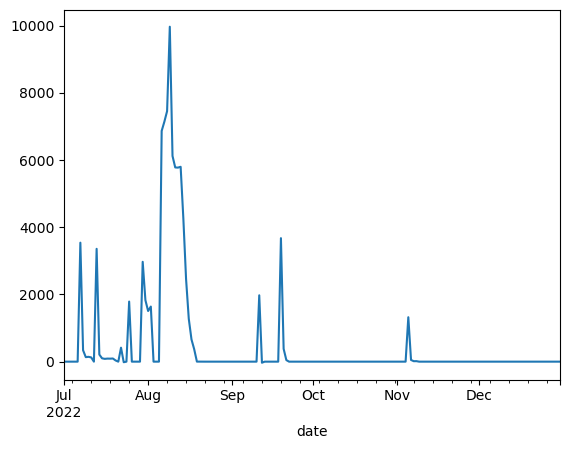

In [225]:
df_perf[(df_perf.index >= pd.Timestamp('2022-07-01')) & (df_perf.index <= pd.Timestamp('2022-12-31'))]['total_actual_position_notional'].plot()

<Axes: xlabel='date'>

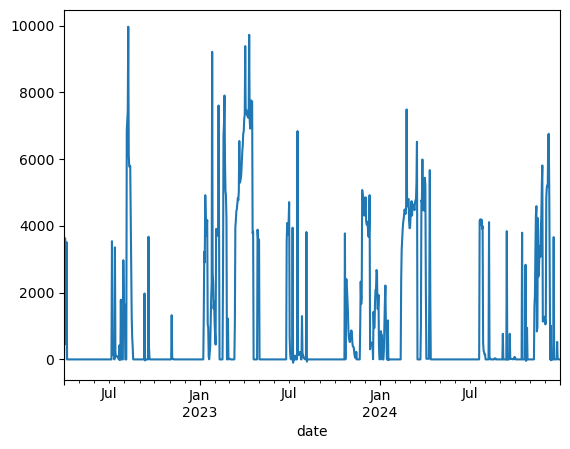

In [191]:
df_perf['total_actual_position_notional'].plot()

<Axes: xlabel='date'>

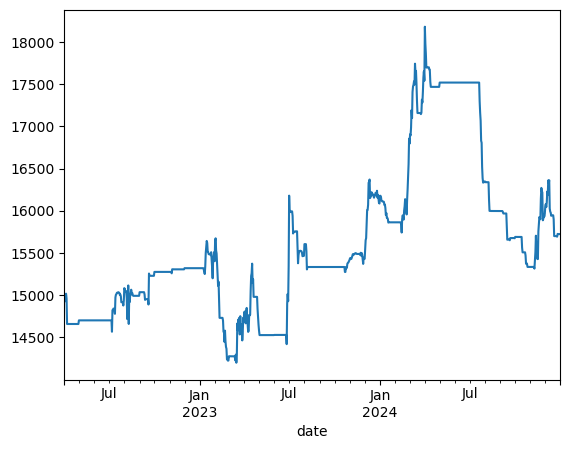

In [53]:
df_perf['total_portfolio_value'].plot()

<Axes: xlabel='date'>

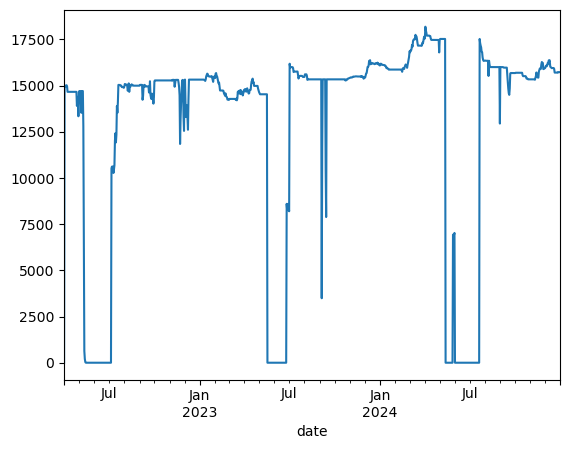

In [73]:
df_perf['total_target_notional'].plot()

<Axes: xlabel='date'>

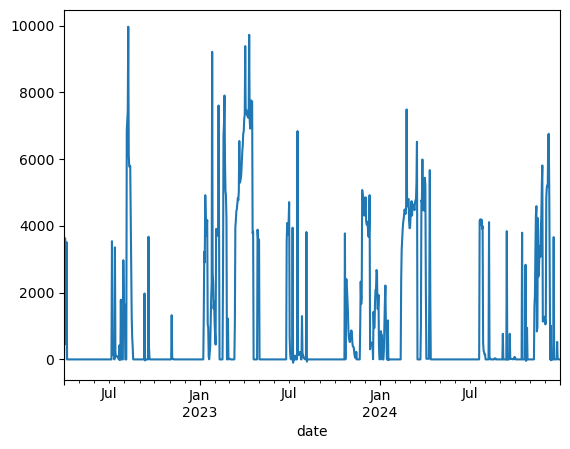

In [55]:
df_perf['total_actual_position_notional'].plot()

<Axes: xlabel='date'>

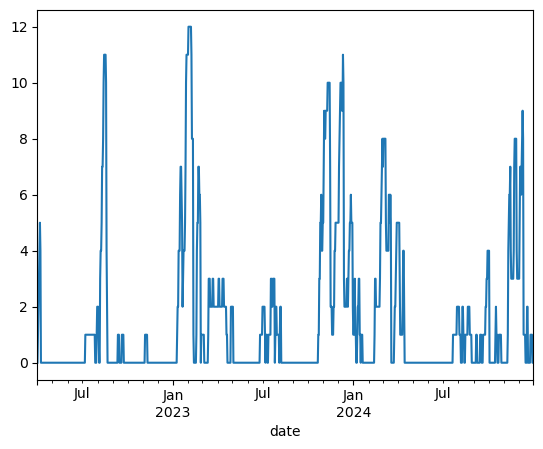

In [227]:
df_perf['count_of_positions'].plot()

In [ ]:
df_perf.head()

In [59]:
df_perf = size_bin.calculate_portfolio_returns(df_perf, rolling_sharpe_window)
portfolio_perf_metrics_expanded_universe = calculate_risk_and_performance_metrics(df_perf, strategy_daily_return_col=f'portfolio_daily_pct_returns',
                                                                                  strategy_trade_count_col=f'count_of_positions', include_transaction_costs_and_fees=False, passive_trade_rate=0.05, annual_trading_days=365, transaction_cost_est=0.001)
portfolio_perf_metrics_expanded_universe

{'annualized_return': 0.017248502251846265,
 'annualized_sharpe_ratio': -0.2866069611772085,
 'calmar_ratio': 0.10936006916402313,
 'annualized_std_dev': 0.14474399015613146,
 'max_drawdown': -0.15772212274277359,
 'max_drawdown_duration': Timedelta('274 days 00:00:00'),
 'hit_rate': 0.20278330019880716,
 't_statistic': 0.37714673886228195,
 'p_value': 0.7061441809453548,
 'trade_count': 1508.0}

In [ ]:
df_pos[(df_pos.product_id == 'SOL-USD') & (df_pos['date'] >= pd.Timestamp('2024-01-01'))]

In [ ]:
df_pos[df_pos.final_signal > 0].groupby(['date']).agg({'product_id':'nunique'})

In [ ]:
df_perf[df_perf.index >= pd.Timestamp('2024-04-01')].head()

In [ ]:
df_pos[df_pos['date'] == pd.Timestamp('2024-04-01')][['product_id','final_signal','target_notional','actual_position_notional']].sort_values('final_signal', ascending=False)

In [ ]:
df_pos[(df_pos['date'] == pd.Timestamp('2024-04-01')) & (df_pos.product_id == 'MKR-USD')]

In [ ]:
4075.0 - 1.75 * 285.351574

## Final Trend Following Signal Analysis

In [ ]:
df_pos.to_pickle("/Users/adheerchauhan/Documents/git/trend_following/research/backtest_results/expanded_universe/Daily_Positions_Notional_Pct_Change-2022-04-01_2024-12-31.pickle")
df_open.to_pickle("/Users/adheerchauhan/Documents/git/trend_following/research/backtest_results/expanded_universe/Monthly_Open_Positions_Notional_Pct_Change-2022-04-01_2024-12-31.pickle")
df_perf.to_pickle("/Users/adheerchauhan/Documents/git/trend_following/research/backtest_results/expanded_universe/Daily_Performance_Notional_Pct_Change-2022-04-01_2024-12-31.pickle")

In [ ]:
df_pos = pd.read_pickle("/Users/adheerchauhan/Documents/git/trend_following/research/backtest_results/expanded_universe/Daily_Positions_Notional_Pct_Change-2022-04-01_2024-12-31.pickle")
df_open = pd.read_pickle("/Users/adheerchauhan/Documents/git/trend_following/research/backtest_results/expanded_universe/Monthly_Open_Positions_Notional_Pct_Change-2022-04-01_2024-12-31.pickle")
df_perf = pd.read_pickle("/Users/adheerchauhan/Documents/git/trend_following/research/backtest_results/expanded_universe/Daily_Performance_Notional_Pct_Change-2022-04-01_2024-12-31.pickle")

In [ ]:
thresh = 1e-8

# 1) Detect entries (actual_position_notional turns from ~0 to >0)
df_pos['lag_notional'] = df_pos.groupby('product_id')['actual_position_notional'].shift()
entries = df_pos[(df_pos['lag_notional'].fillna(0)<=thresh) & (df_pos['actual_position_notional']>thresh)].copy()

# 2) Reconstruct close and daily returns per product_id
df_pos['close'] = df_pos.groupby('product_id')['t_1_close'].shift(-1)

for h in (5, 10, 20):
    df_pos[f'fwd_{h}d'] = (
        df_pos.groupby('product_id')['close'].shift(-h) / df_pos['close']
        - 1.0
    )

# 4) Attach forward returns at the entry date
fwd_cols = ['fwd_5d','fwd_10d','fwd_20d']
entry_fwd = entries[['date','product_id','final_signal']].merge(
    df_pos[['date','product_id']+fwd_cols], on=['date','product_id'], how='left'
)

# 5) Bucketize by final_signal (tune bins if you later z-score/percentile-rank)
bins = [-np.inf, 0.00, 0.25, 0.50, 0.75, np.inf]
labels = ['<=0','0–0.25','0.25–0.5','0.5–0.75','>0.75']
entry_fwd['signal_bucket_raw_signal'] = pd.cut(entry_fwd['final_signal'], bins=bins, labels=labels)

entry_fwd['signal_prank'] = (
    entry_fwd.groupby('date')['final_signal']
             .rank(pct=True)
)
bins = [0, .2, .4, .6, .8, 1.0]
labels = ['0–20%','20–40%','40–60%','60–80%','80–100%']
entry_fwd['signal_bucket_percentile_ranks'] = pd.cut(entry_fwd['signal_prank'], bins=bins, labels=labels, include_lowest=True)


sig_bucket_summary_raw_signal = entry_fwd.groupby('signal_bucket_raw_signal')[fwd_cols].agg(['mean','median','count'])
sig_bucket_hits_raw_signal    = entry_fwd.groupby('signal_bucket_raw_signal')[fwd_cols].apply(lambda s: (s>0).mean()).add_suffix('_hit')

sig_bucket_summary_percentile_ranks = entry_fwd.groupby('signal_bucket_percentile_ranks')[fwd_cols].agg(['mean','median','count'])
sig_bucket_hits_percentile_ranks    = entry_fwd.groupby('signal_bucket_percentile_ranks')[fwd_cols].apply(lambda s: (s>0).mean()).add_suffix('_hit')


In [ ]:
df_pos[df_pos.product_id == 'MKR-USD'][['date','product_id','close', 'fwd_5d', 'fwd_10d', 'fwd_20d']]#.head(20)

In [ ]:
df_pos[(df_pos.product_id == 'MKR-USD') & (df_pos['date'] >= pd.Timestamp('2024-03-30'))][['date','product_id','close', 'fwd_5d', 'fwd_10d', 'fwd_20d']]#.head(20)

In [ ]:
entry_fwd.groupby(['signal_bucket_raw_signal','signal_bucket_percentile_ranks']).size()

In [ ]:
sig_bucket_summary_raw_signal

In [ ]:
sig_bucket_hits_raw_signal

In [ ]:
sig_bucket_summary_percentile_ranks

In [ ]:
sig_bucket_hits_percentile_ranks

In [ ]:
df_pos.head()

In [ ]:
df_pos.groupby(['product_id']).agg({'actual_position_notional':'sum'}).sort_values('actual_position_notional', ascending=False)#.head(10).index

## Prod Signal with Top 10 Coins by Notional from Expanded Universe

In [ ]:
expanded_universe_ticker_list_10 = ['BTC-USD', 'ETH-USD', 'LTC-USD', 'XRP-USD', 'BCH-USD', 'ALGO-USD',
                                    'ADA-USD', 'XLM-USD', 'AAVE-USD', 'UNI-USD']


## T-Cost Analysis

In [ ]:
df_pos = df_pos.sort_values(['date','product_id'])
df_pos['trade_notional'] = df_pos.groupby('product_id')['actual_position_notional'].diff().fillna(0.0).abs()

# Simple, conservative cost model (bps)
# – replace with your live TC model if you have one
df_pos['cost_bps'] = 127#8 + 35*np.sqrt((df_pos['trade_notional'] / df_pos['trade_notional'].replace(0,np.nan).rolling(30).median()).clip(0,3)).fillna(8)

df_pos['est_cost_usd'] = df_pos['trade_notional'] * df_pos['cost_bps'] / 1e4

# Daily aggregates
daily_traded = df_pos.groupby('date')['trade_notional'].sum().to_frame('traded_notional_usd')
daily_costs  = df_pos.groupby('date')['est_cost_usd'].sum().to_frame('est_cost_usd')

turnover_df = daily_traded.join(daily_costs).join(df_perf[['portfolio_daily_pct_returns']])
turnover_df['net_portfolio_ret_est'] = turnover_df['portfolio_daily_pct_returns'] - (turnover_df['est_cost_usd']/df_perf['total_portfolio_value'])


In [ ]:
turnover_df.head(20)

In [ ]:
perf.estimate_fee_per_trade(passive_trade_rate=passive_trade_rate) + transaction_cost_est

In [ ]:
turnover_df[['portfolio_daily_pct_returns','net_portfolio_ret_est']].plot()

In [ ]:
turnover_df[['portfolio_daily_pct_returns','net_portfolio_ret_est']].plot()

In [ ]:
df_pos[df_pos.trade_notional != 0].head()

In [ ]:
df_perf.head()

In [ ]:
df_perf.reset_index().groupby(['date']).agg({'count_of_positions':'sum','total_actual_position_notional':'sum'}).sort_values('count_of_positions', ascending=False)

In [ ]:
df_perf['available_cash'].plot()

In [ ]:
df_perf['total_portfolio_value'].plot()

In [ ]:
df_perf['total_actual_position_notional'].plot()

In [ ]:
df_pos.head()#[df_pos.event != 'No Position'].groupby(['date']).agg({'product_id':'nunique'})

In [ ]:
df_pos.groupby(['product_id']).agg({'actual_position_notional':'sum'}).sort_values('actual_position_notional', ascending=False)

In [ ]:
df_pos[df_pos.product_id == 'BTC-USD'][['final_signal']].plot(figsize=(10,8))#.head(20)

In [ ]:
df_pos[df_pos.product_id == 'BTC-USD'][['actual_position_notional']].plot(figsize=(10,8))#.head(20)

In [ ]:
df_pos[df_pos.product_id == 'BTC-USD'][['final_signal','actual_position_notional']]#.head(20)

In [ ]:
signal_bins = [-np.inf, 0.0001, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1]
df_pos['final_signal_bins'] = pd.cut(df_pos['final_signal'], bins=signal_bins)

In [ ]:
thresh = 1e-8

# 1) Detect entries (actual_position_notional turns from ~0 to >0)
df_pos['lag_notional'] = df_pos.groupby('product_id')['actual_position_notional'].shift()
entries = df_pos[(df_pos['lag_notional'].fillna(0) <= thresh) & (df_pos['actual_position_notional'] > thresh)].copy()

# 2) Reconstruct close and daily returns per product_id
df_pos['close'] = df_pos.groupby('product_id')['t_1_close'].shift(-1)
df_pos['ret']   = df_pos.groupby('product_id')['close'].pct_change()

In [ ]:
df_pos.groupby(['final_signal_bins']).agg({'actual_position_notional':'sum', 'ret': ['median','mean']})

In [ ]:
df_pos[df_pos.final_signal > 0.09].groupby(['final_signal_bins','product_id']).agg({'actual_position_notional':'sum', 'ret': ['median','mean']}).dropna()

In [ ]:
df_perf[df_perf.index >= pd.Timestamp('2022-07-06')].head(20)

In [ ]:
df_pos[(df_pos.date > pd.Timestamp('2022-07-05')) & (df_pos.event != 'No Position')].head(20)

In [ ]:
df_pos[(df_pos.final_signal > 0.1) & (df_pos.product_id == 'UNI-USD')].head(20)

In [ ]:
ranks = df_pos['final_signal'].rank(method='first')
df_pos['final_signal_quantiles'] = pd.qcut(ranks, q=7)


In [ ]:
df_pos.shape

In [ ]:
df_pos.groupby(['final_signal_quantiles']).agg({'final_signal': ['median', 'mean'], 'actual_position_notional': 'sum'})

In [ ]:
df_pos[df_pos.product_id == 'BTC-USD']['final_signal'].describe()

In [ ]:
import matplotlib.pyplot as plt

df_pos[df_pos.product_id == 'BTC-USD']['final_signal'].hist(bins=30)  # adjust bins as needed
plt.xlabel('final_signal')
plt.ylabel('Frequency')
plt.title('Distribution of final_signal')
plt.show()


In [ ]:
df_open

In [ ]:
df_perf[df_perf.index >= pd.Timestamp('2022-07-30')].head()

In [ ]:
df_pos[(df_pos.date >= pd.Timestamp('2022-07-30')) & (df_pos.product_id == 'ICP-USD')].head()

In [ ]:
df_pos[(df_pos.date >= pd.Timestamp('2024-11-20')) & (df_pos.product_id == 'BTC-USD')].head(20)

In [ ]:
df_pos.groupby(['event']).size()

In [ ]:
df_pos[df_pos.event == 'Stop-Loss Cooldown']

In [ ]:
df_pos[(df_pos.date >= pd.Timestamp('2022-04-04')) & (df_pos.product_id == 'ICP-USD')].head(20)

In [ ]:
df_perf.head()

In [ ]:
df_perf = size_bin.calculate_portfolio_returns(df_perf, rolling_sharpe_window=50)

In [ ]:
df_perf.head()

In [ ]:
df_perf['portfolio_strategy_cumulative_return'].plot()

In [ ]:
print('Calculating In Sample Asset Returns!!')
# df_final_prod_config_backtested = perf.calculate_asset_level_returns(df_final_prod_config_backtested, end_date, ticker_list)

portfolio_perf_metrics_prod_config = calculate_risk_and_performance_metrics(df_perf, strategy_daily_return_col=f'portfolio_daily_pct_returns',
                                                                           strategy_trade_count_col=f'count_of_positions', include_transaction_costs_and_fees=False, passive_trade_rate=0.05, annual_trading_days=365, transaction_cost_est=0.001)
portfolio_perf_metrics_prod_config